In [26]:
#automatically reload stuff
%load_ext autoreload
%autoreload 2
import Utils
import matplotlib.pyplot as plt
from SpatialPreprocessing import *
import json
import Formatting
from Constants import Const
import copy
import Metrics
import Models
import re
import Cluster
pd.set_option('display.max_columns', None)

from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import seaborn as sns

from Levenshtein import distance as levenshtein_distance
import collections

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from warnings import simplefilter 
simplefilter(action='ignore')

In [21]:
# rds = RadDataset()
rds.get_value_array(
    ['mean_dose','V10','V40'],
                    keep_2d=False,
                    organ_list =['MPC',"SPC",'IPC']).shape

(484, 40, 3)

In [31]:
feature_candidates = [
    ['V25','V35','V45','V55'],
    ['V15','V45','V65'],
    ['mean_dose','V65','V55','V45','V35','V25','V15'],
    ['mean_dose'],
    ['V55'],
    ['V35'],
#     ['mean_dose','V60'],
#     ['mean_dose','V10','V65'],
#     ['V10','V60'],
#     ['V15','V60'],
#     ['V10','V20','V60'],
#     ['V15','V25','V35','V45','V55','V65'],
#     ['V15','V20','V25','V30','V35','V40','V45','V50','V55','V60'],
#     ['V5','V10','V15','V20','V25','V30','V35','V40','V45','V50','V55','V60','V65','V70','V75','V80'],
]
n_clusters = [3,4,5]
sim_measure_dict = {
        'euclidean': Metrics.Euclidean2D(),
#         'cosine': Metrics.Cosine2d(),
#         'chi2': Metrics.ChiSquared2d(),
        'jaccard': Metrics.Jaccard2d(),
       'em': Metrics.Wasserstein2d(),
    }
links = ['ward','weighted']
results = []
organ_subsets = [
    #swallowing muscles
    [
        'Cricopharyngeal_Muscle',
        'Esophagus',
        'IPC',
        'MPC',
        'SPC',
        'Mylogeniohyoid_M',
        'Supraglottic_Larynx',
        'Tongue',
        'Rt_Masseter_M',
        'Lt_Masseter_M',
    ],
    #stuff correlated with symptom clusters
    ['Lower_Lip','Spinal_Cord',
     'Brainstem','Lt_Mastoid',
     'Rt_Mastoid','Upper_Lip',
     'Esophagus'],
    #stuff correlated with dysphagia stuff
    ['MPC',
     'Thyroid_cartilage',
     'Mylogeniohyoid_M',
     'Brainstem',"IPC",
     'Tongue',
     'Cricoid_cartilage',
     'Extended_Oral_Cavity',
     'Genioglossus_M',
    ],
    None
]
for features in feature_candidates:
    print(features)
    for organ_subset in organ_subsets:
        is_2d = len(features) < 3
        array = rds.get_value_array(features,
                                    keep_2d= False,
                                    as_df=False,
                                    organ_list=organ_subset,
                                   )
        for n in n_clusters:
            for link in links:
                clusterer = Cluster.SimilarityClusterer(n,link=link)
                for sname, sim in sim_measure_dict.items():
                    try:
                        sim_matrix = sim.get_similarity_matrix(array)
                        clusters = clusterer.fit_predict(sim_matrix)
                        sscore = clusterer.silhouette()

                        res = {
                            "clusters": clusters, 
                            'silhouette': sscore,
                            'sim_matrix':sim_matrix,
                            'n_clusters': n,
                            'link': link,
                            'features': features,
                            'clusters': clusters,
                            'measure': sname,
                            'organ_subset':'|'.join(organ_subset),
                              }
                        results.append(res)
                        dont_print = set(['clusters','sim_matrix'])
                        print([(k,v) for k,v in res.items() if k not in dont_print])
                    except Exception as e:
                        print(e)
pd.DataFrame(results)

['V25', 'V35', 'V45', 'V55']
[('silhouette', 0.08919609305977237), ('n_clusters', 3), ('link', 'ward'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.02624978367414312), ('n_clusters', 3), ('link', 'ward'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'jaccard'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.08399283081320048), ('n_clusters', 3), ('link', 'ward'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'em'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.04683807312719685), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measur

[('silhouette', 0.009551589542963064), ('n_clusters', 5), ('link', 'ward'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'jaccard'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.1958095192303744), ('n_clusters', 5), ('link', 'ward'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'em'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.12244726167430063), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'euclidean'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.09183452691902734), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V25', 'V35', 'V45', 'V55']), ('measure', 'jaccard'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.1858472750436933), ('n_cl

[('silhouette', 0.11407792909334015), ('n_clusters', 4), ('link', 'ward'), ('features', ['V15', 'V45', 'V65']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.017969258596167242), ('n_clusters', 4), ('link', 'ward'), ('features', ['V15', 'V45', 'V65']), ('measure', 'jaccard'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.13323935034184387), ('n_clusters', 4), ('link', 'ward'), ('features', ['V15', 'V45', 'V65']), ('measure', 'em'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.051724707524917965), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V15', 'V45', 'V65']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Mus

[('silhouette', 0.045009355508162395), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V15', 'V45', 'V65']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.04695549082669675), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V15', 'V45', 'V65']), ('measure', 'jaccard'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.07685940729104107), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V15', 'V45', 'V65']), ('measure', 'em'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.059268730943054376), ('n_clusters', 4), ('link', 'ward'), ('features', ['V15', 'V45', 'V65']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilag

[('silhouette', 0.046040164961286094), ('n_clusters', 5), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.002547185861279761), ('n_clusters', 5), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'jaccard'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.07243937175073303), ('n_clusters', 5), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'em'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.027247728051659096), ('n_clusters', 5), ('link', 'weighted'

[('silhouette', 0.04203477344242889), ('n_clusters', 4), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.0008524656210177915), ('n_clusters', 4), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'jaccard'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.07593997098003023), ('n_clusters', 4), ('link', 'ward'), ('features', ['mean_dose', 'V65', 'V55', 'V45', 'V35', 'V25', 'V15']), ('measure', 'em'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.02884593329297764), ('n_clusters', 4), ('link', 'weighted'), ('featu

[('silhouette', 0.05802653277544141), ('n_clusters', 5), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'jaccard'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.1120458028511134), ('n_clusters', 5), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'em'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.1436266857410698), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'euclidean'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.0036182108896121398), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'jaccard'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0

[('silhouette', 0.1247504697683093), ('n_clusters', 5), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'em'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.10462274900138298), ('n_clusters', 5), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.0420946587920194), ('n_clusters', 5), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'jaccard'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.10462274900138298), ('n_clusters', 5), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'em'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cri

[('silhouette', 0.01609076639932612), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V55']), ('measure', 'jaccard'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.43542748913687124), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V55']), ('measure', 'em'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.2816346860237104), ('n_clusters', 5), ('link', 'ward'), ('features', ['V55']), ('measure', 'euclidean'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.015612740977403538), ('n_clusters', 5), ('link', 'ward'), ('features', ['V55']), ('measure', 'jaccard'), ('organ_subset', 'Lower_Lip|Spinal_Cord|Brainstem|Lt_Mastoid|Rt_Mastoid|Upper_Lip|Esophagus')]
[('silhouette', 0.2816346860237104), ('n_clusters', 5), ('link', 'ward'), ('features', ['V55']), ('measure', 'em'), ('organ_sub

[('silhouette', 0.19014663813079719), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.05748324498470792), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'jaccard'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.19014663813079719), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'em'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M')]
[('silhouette', 0.17009883484080324), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35']), ('measure', 'euclidean'), ('organ_subset', 'Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_La

[('silhouette', 0.3359364389443438), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.027770716118869658), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'jaccard'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.3359364389443438), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'em'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_Oral_Cavity|Genioglossus_M')]
[('silhouette', 0.3204527024861894), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35']), ('measure', 'euclidean'), ('organ_subset', 'MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainstem|IPC|Tongue|Cricoid_cartilage|Extended_O

clusters  silhouette  \
0    [2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...    0.089196   
1    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    0.026250   
2    [1, 1, 1, 2, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1, 1, ...    0.083993   
3    [2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...    0.046838   
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    0.084295   
..                                                 ...         ...   
316  [1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, ...    0.333785   
317  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    0.026868   
318  [1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, ...    0.333785   
319  [5, 5, 5, 5, 3, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, ...    0.337122   
320  [5, 5, 5, 5, 3, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, ...    0.337122   

                                            sim_matrix  n_clusters      link  \
0    [[1.0, 0.018442860038209646, 0.012390591337917...           3      ward   
1    [[0.0, 0.034604941051588956, 0.065537982544438...           3      ward   
2    [[1.0, 0.06853595565342852, 0.0518072482659963...           3      ward   
3    [[1.0, 0.018442860038209646, 0.012390591337917...           3  weighted   
4    [[0.0, 0.034604941051588956, 0.065537982544438...           3  weighted   
..                                                 ...         ...       ...   
316  [[1.0, 1.0, 1.0, 1.0, 0.009124260355029586, 1....           5      ward   
317  [[0.0, 0.0, 0.0, 0.0, 0.21786459153935667, 0.0...           5      ward   
318  [[1.0, 1.0, 1.0, 1.0, 0.009124260355029586, 1....           5      ward   
319  [[1.0, 1.0, 1.0, 1.0, 0.009124260355029586, 1....           5  weighted   
320  [[1.0, 1.0, 1.0, 1.0, 0.009124260355029586, 1....           5  weighted   

                 features    measure  \
0    [V25, V35, V45, V55]  euclidean   
1    [V25, V35, V45, V55]    jaccard   
2    [V25, V35, V45, V55]         em   
3    [V25, V35, V45, V55]  euclidean   
4    [V25, V35, V45, V55]    jaccard   
..                    ...        ...   
316                 [V35]  euclidean   
317                 [V35]    jaccard   
318                 [V35]         em   
319                 [V35]  euclidean   
320                 [V35]         em   

                                          organ_subset  
0    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
1    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
2    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
3    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
4    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
..                                                 ...  
316  MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainst...  
317  MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainst...  
318  MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainst...  
319  MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainst...  
320  MPC|Thyroid_cartilage|Mylogeniohyoid_M|Brainst...  

[321 rows x 8 columns]

In [32]:
pd.DataFrame(results).to_pickle('dvh_cluster_test_results.pk')

In [36]:
result_df = pd.read_pickle('dvh_cluster_test_results.pk')#pd.DataFrame(results)
result_df = result_df[result_df.organ_subset.apply(lambda x: 'Supraglottic_Larynx' in x)]
result_df.sort_values('silhouette',ascending=False)

clusters  silhouette  \
219  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    0.356010   
221  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    0.356010   
225  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    0.352170   
227  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    0.352170   
233  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...    0.349746   
..                                                 ...         ...   
229  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    0.001656   
109  [1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 3, ...    0.001546   
175  [5, 5, 1, 5, 5, 4, 4, 3, 5, 4, 5, 5, 5, 5, 5, ...    0.001338   
169  [4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, ...    0.001241   
163  [3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, ...    0.001057   

                                            sim_matrix  n_clusters      link  \
219  [[1.0, 0.1342052426101506, 0.18049408297647004...           3  weighted   
221  [[1.0, 0.1342052426101506, 0.18049408297647004...           3  weighted   
225  [[1.0, 0.1342052426101506, 0.18049408297647004...           4  weighted   
227  [[1.0, 0.1342052426101506, 0.18049408297647004...           4  weighted   
233  [[1.0, 0.1342052426101506, 0.18049408297647004...           5  weighted   
..                                                 ...         ...       ...   
229  [[0.0, 0.27091297517473834, 0.8782255014901807...           5      ward   
109  [[0.0, 0.023463169098877135, 0.044451927821858...           3      ward   
175  [[0.0, 0.0028986153076675514, 0.01033987981372...           5      ward   
169  [[0.0, 0.0028986153076675514, 0.01033987981372...           4      ward   
163  [[0.0, 0.0028986153076675514, 0.01033987981372...           3      ward   

                                      features    measure  \
219                                      [V55]  euclidean   
221                                      [V55]         em   
225                                      [V55]  euclidean   
227                                      [V55]         em   
233                                      [V55]         em   
..                                         ...        ...   
229                                      [V55]    jaccard   
109  [mean_dose, V65, V55, V45, V35, V25, V15]    jaccard   
175                                [mean_dose]    jaccard   
169                                [mean_dose]    jaccard   
163                                [mean_dose]    jaccard   

                                          organ_subset  
219  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
221  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
225  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
227  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
233  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
..                                                 ...  
229  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
109  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
175  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
169  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  
163  Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...  

[108 rows x 8 columns]

In [34]:
def plot_cluster_histogram(x,clusters,**kwargs):
    vals = np.hstack([x,clusters.reshape(-1,1)])
    print(vals.shape)
    data = pd.DataFrame(vals,columns=['val','cluster'])
    sns.swarmplot(
        data=data,
        x='cluster',
        hue='cluster',
        palette='colorblind',
    )
    
def plot_cluster_embeddings(x,clusters,
                            perplexity=30,
                            **kwargs
                           ):
    
    colors = plt.get_cmap('tab10')
    plot_colors = [colors(c) for c in clusters]
    
    fsize = 10
    nplots = 2
#     nplots= 3
    fig,ax = plt.subplots(1,nplots,figsize=[fsize*nplots,8])
    
    def encircle(p,ax):
        if len(p) < 3:
            return
        hull = ConvexHull(p,qhull_options='QbB')
        poly = plt.Polygon(p[hull.vertices,:],fc='none',ec=colors(l),linewidth=4)
        ax.add_patch(poly)
    
    x_pca = PCA(2).fit_transform(x)
    ax[0].scatter(x_pca[:,0],x_pca[:,1],c=plot_colors)
    ax[0].set_title('PCA')
    
    sim_matrix = kwargs.get('sim_matrix')
    if sim_matrix is not None:
        tsne = TSNE(2,perplexity=perplexity,metric='precomputed')
        x_tsne = tsne.fit_transform(sim_matrix)
    else:
        if x.shape[0] < 10:
            x_pca_2 = PCA(10).fit_transform(x)
        else:
            x_pca_2 = x[:]
        x_tsne = TSNE(2,init='pca',learning_rate='auto',perplexity=perplexity).fit_transform(x_pca_2)
    ax[1].scatter(x_tsne[:,0],x_tsne[:,1],c=plot_colors)
    ax[1].set_title('TSNE')
    
#     x_isomap = Isomap(n_components = 2).fit_transform(x)
#     ax[2].scatter(x_isomap[:,0],x_isomap[:,1],c=plot_colors)
#     ax[2].set_title('Isomap')
    
    
    for l in np.unique(clusters):
        cluster_pca = x_pca[clusters==l]
        encircle(cluster_pca,ax[0])
        cluster_tsne = x_tsne[clusters==l]
        encircle(cluster_tsne,ax[1])
#         cluster_isomap = x_isomap[clusters==l]
#         encircle(cluster_isomap,ax[2])
    return fig,ax
        
def get_best_results(res_df, select_by='silhouette',minimize=False,**kwargs):
    for k,v in kwargs.items():
        if Utils.iterable(v) and type(v) != type('string'):
            valid = res_df[k].apply(lambda x: ''.join(x)) == ''.join(v)
            res_df =res_df[valid]
        else:
            res_df = res_df[res_df[k] == v]
    best = res_df.sort_values(select_by,ascending=minimize).iloc[0]
    return best

def plot_dvh_results(result_df,r_dset,plot_features=None,**kwargs):
    best = get_best_results(result_df,**kwargs)
    clusters= best.clusters
    print(best)
    if plot_features is None:
        plot_features = best.features
    x = r_dset.get_value_array(plot_features, keep_2d= True)
    if x.shape[0] == 1:
        plot_cluster_histogram(x,clusters)
    else:
        plot_cluster_embeddings(x,clusters)

clusters        [3, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, ...
silhouette                                                0.27989
sim_matrix      [[1.0, 0.1342052426101506, 0.18049408297647004...
n_clusters                                                      4
link                                                         ward
features                                                    [V55]
measure                                                        em
organ_subset    Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|M...
Name: 224, dtype: object


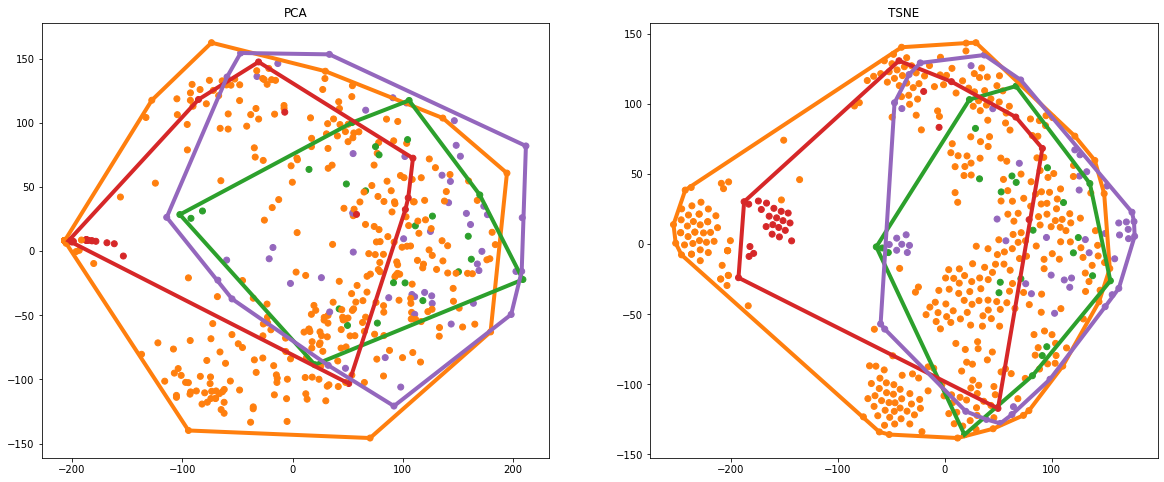

In [45]:
# temp_features=['mean_dose','V10','V65']
# temp_features=['V15','V25','V35','V45','V55','V65']
# temp_features=['mean_dose']
# temp_features=['V5','V10','V15','V20','V25','V30','V35','V40','V45','V50','V55','V60','V65','V70','V75','V80']
# temp_features = ['V25','V35','V45','V55']
plot_dvh_results(result_df,rds,
                 link='ward',
                 measure='em',
                 n_clusters=4,
#                  features=['V55'],
#                  features=temp_features
                )

Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Supraglottic_Larynx|Tongue|Rt_Masseter_M|Lt_Masseter_M
Cricopharyngeal_Muscle|Esophagus|IPC|MPC|SPC|Mylogeniohyoid_M|Su

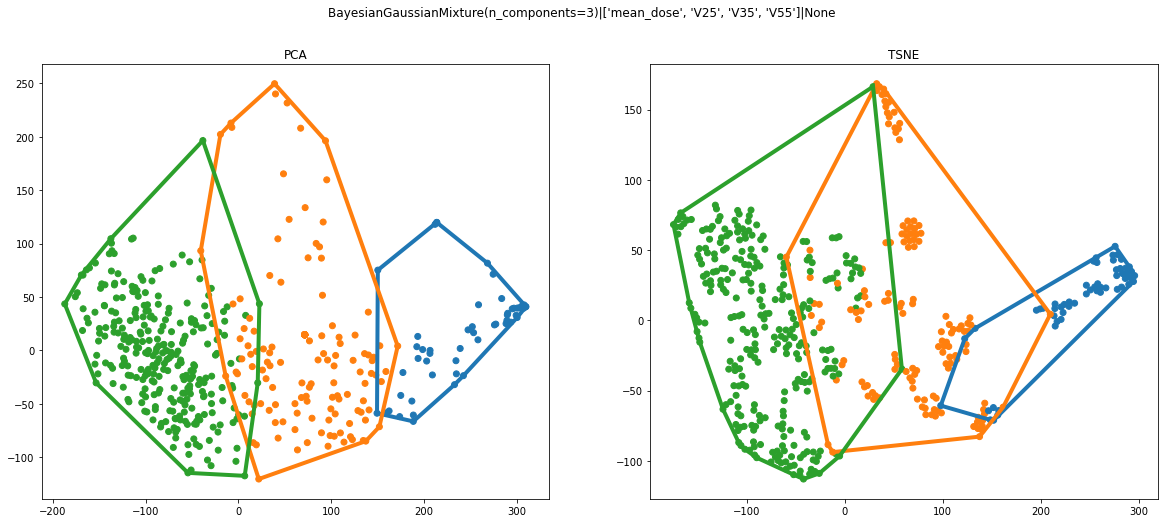

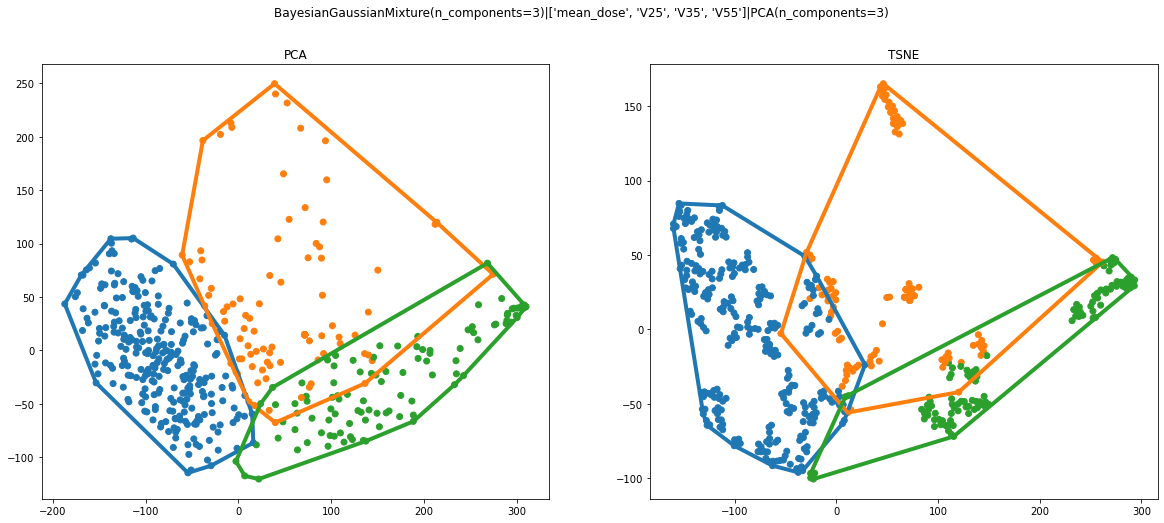

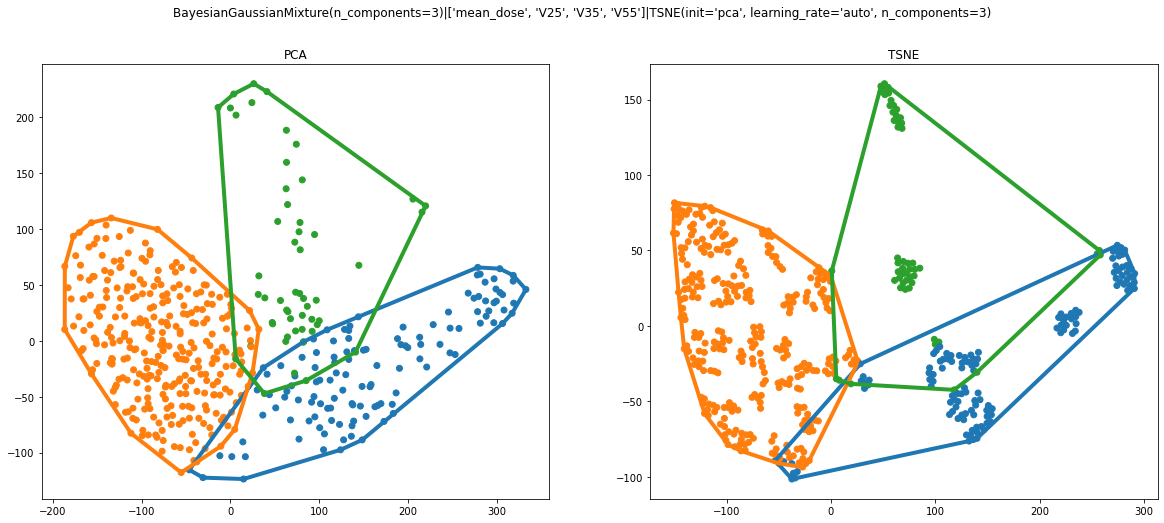

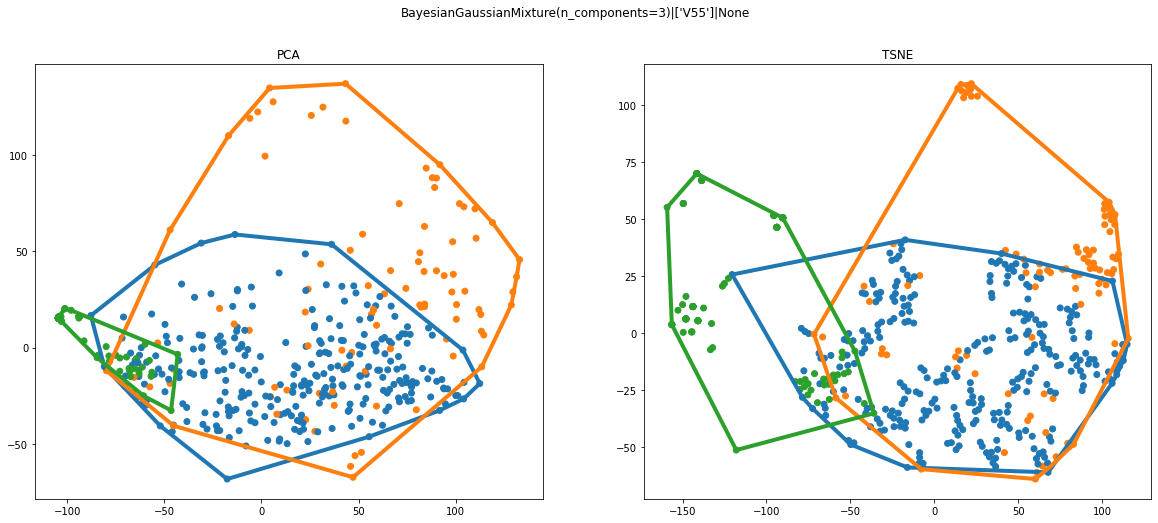

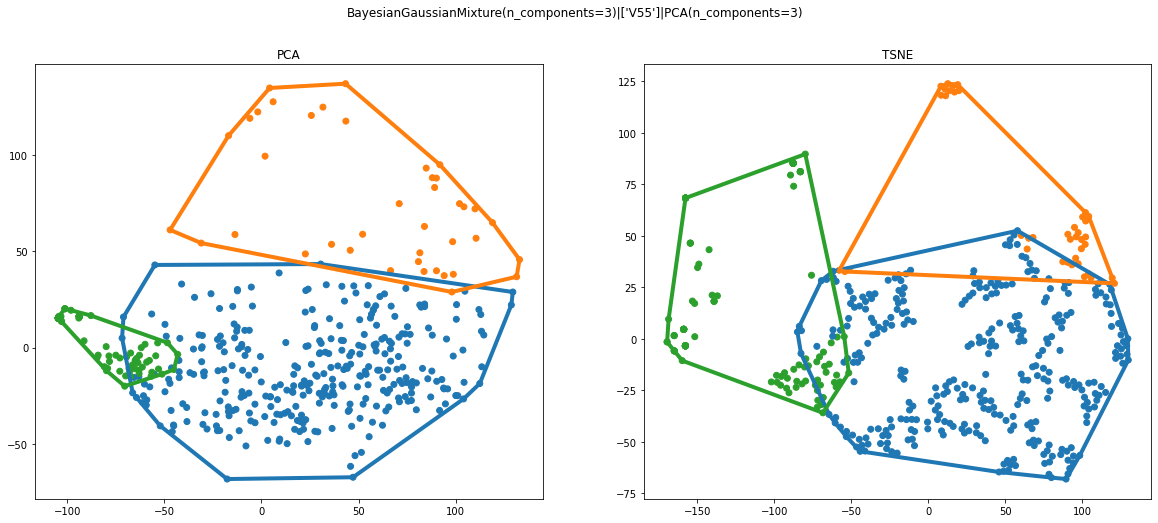

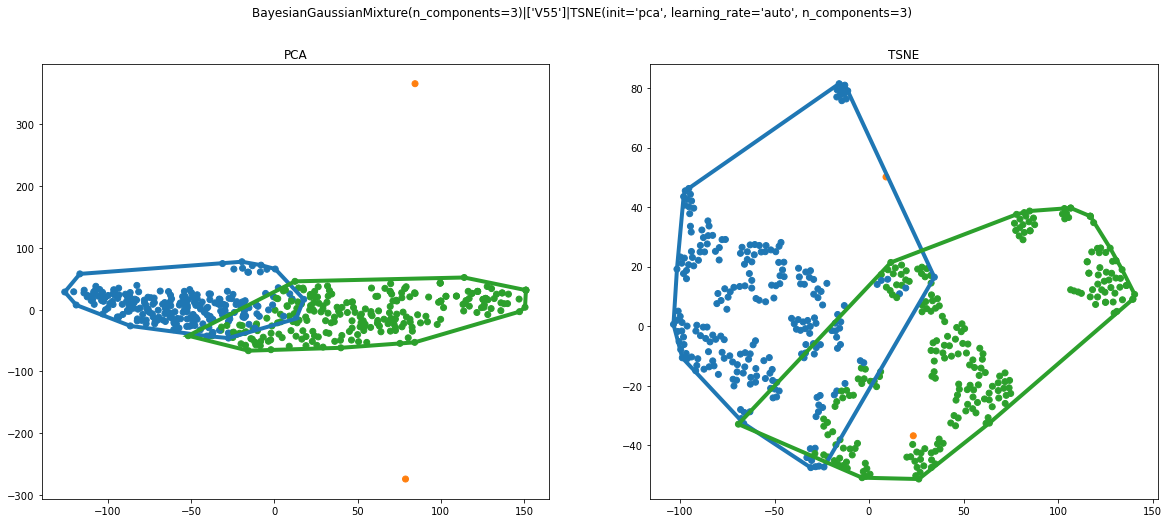

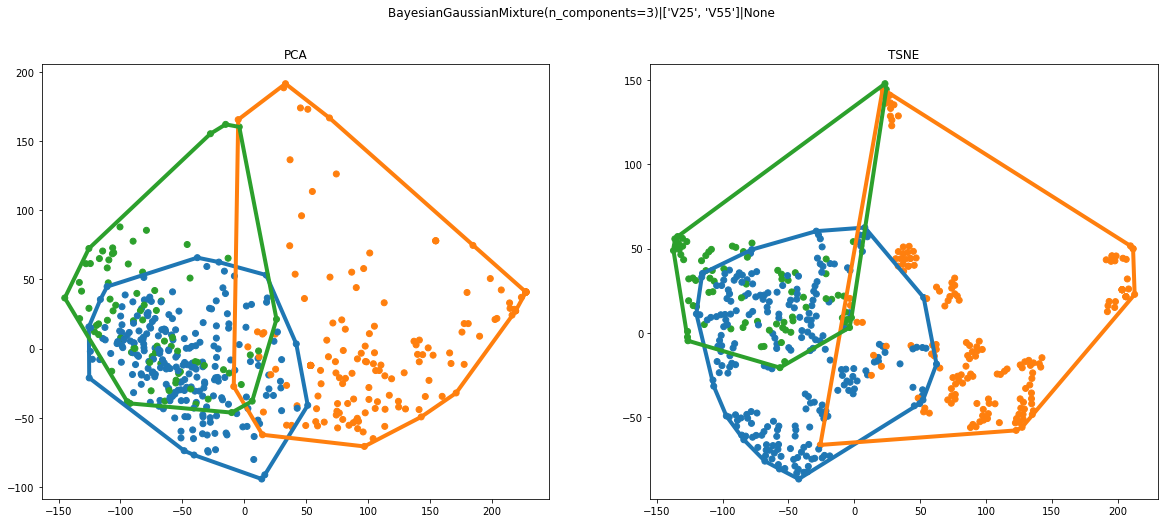

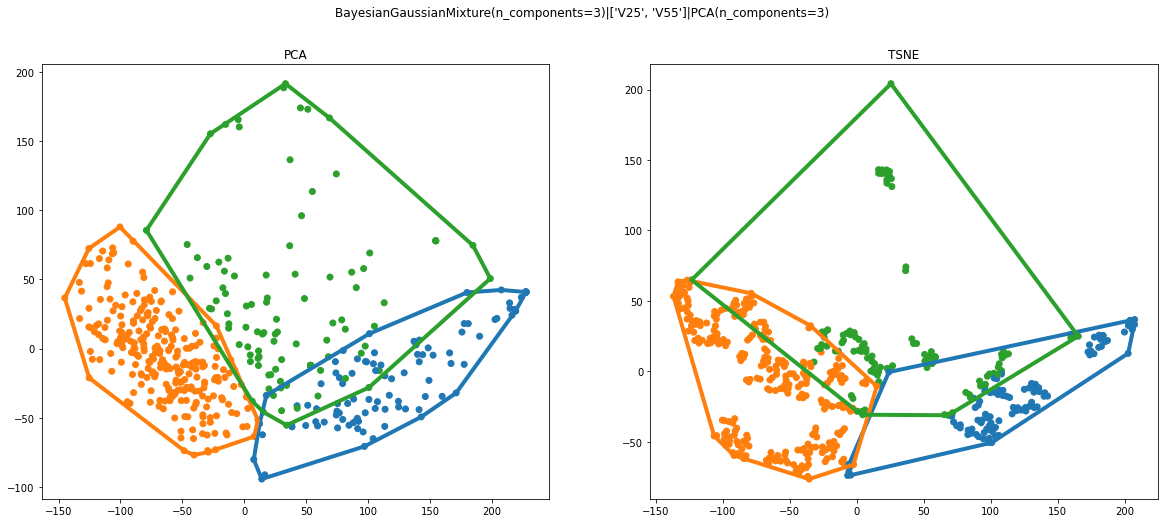

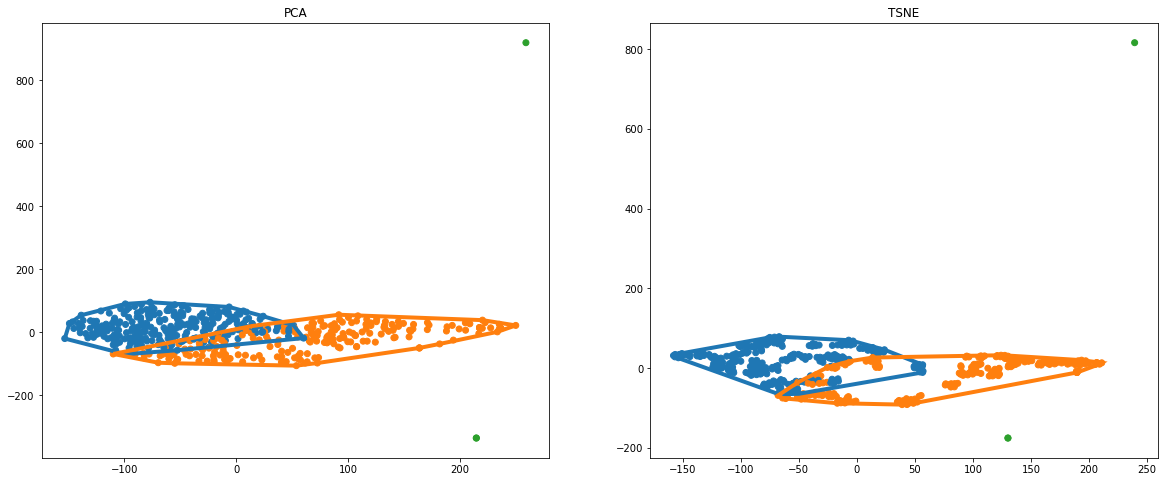

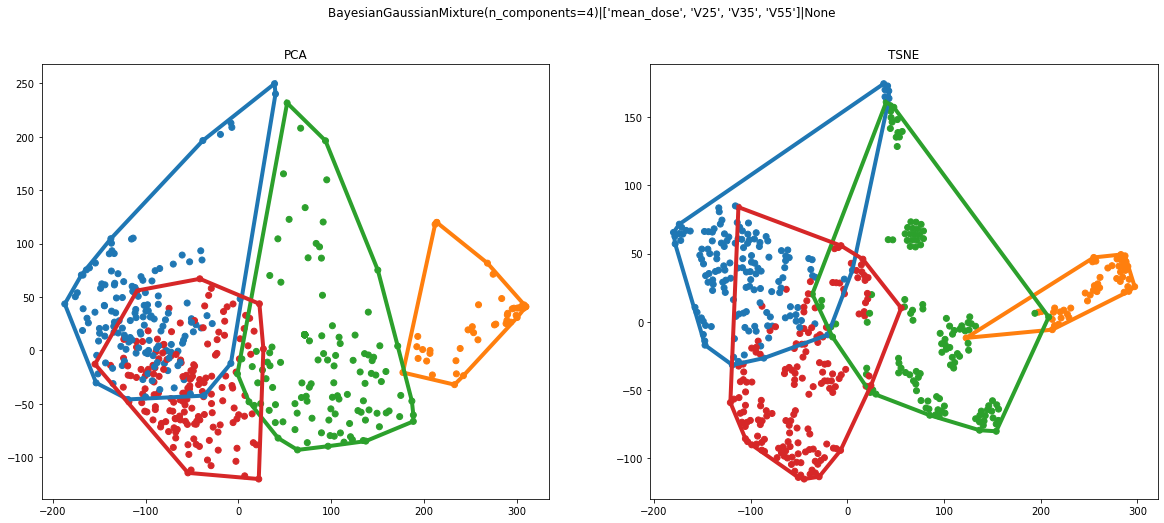

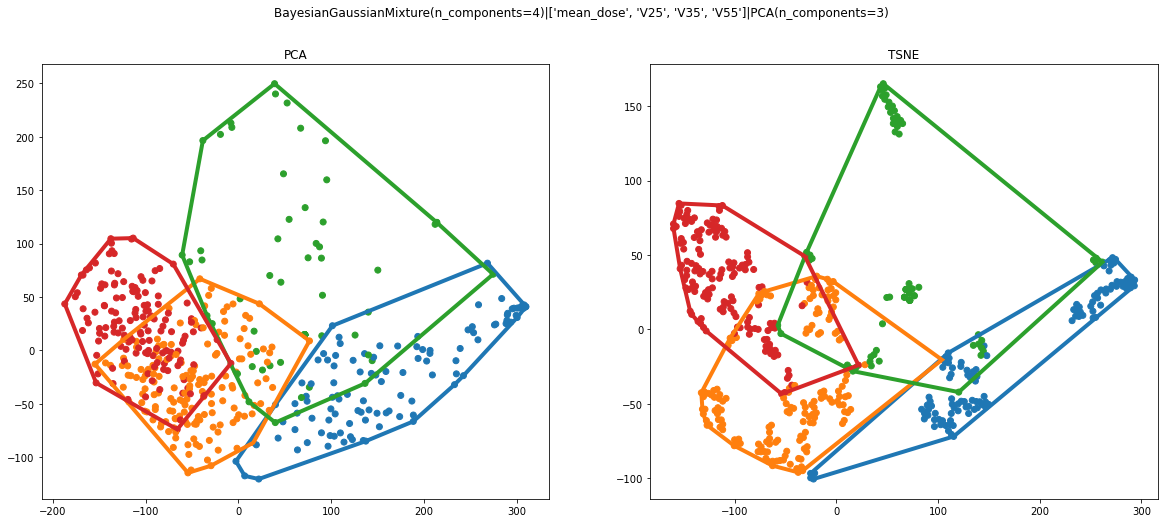

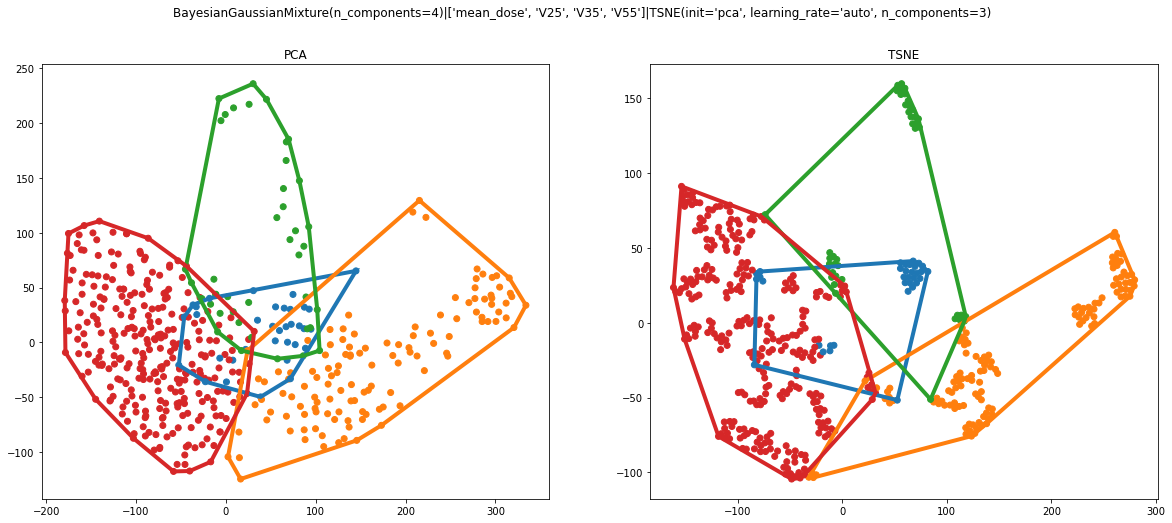

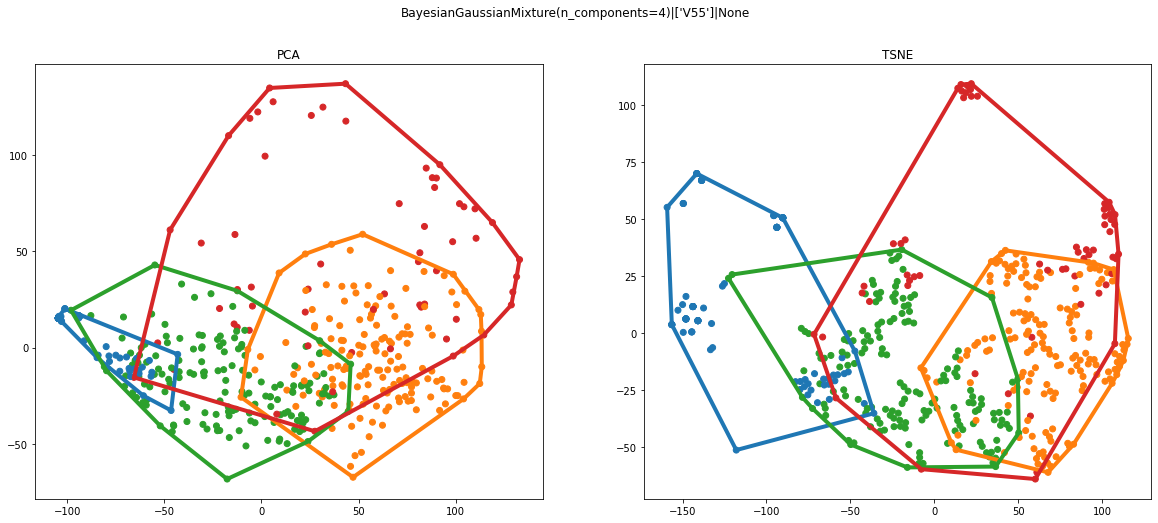

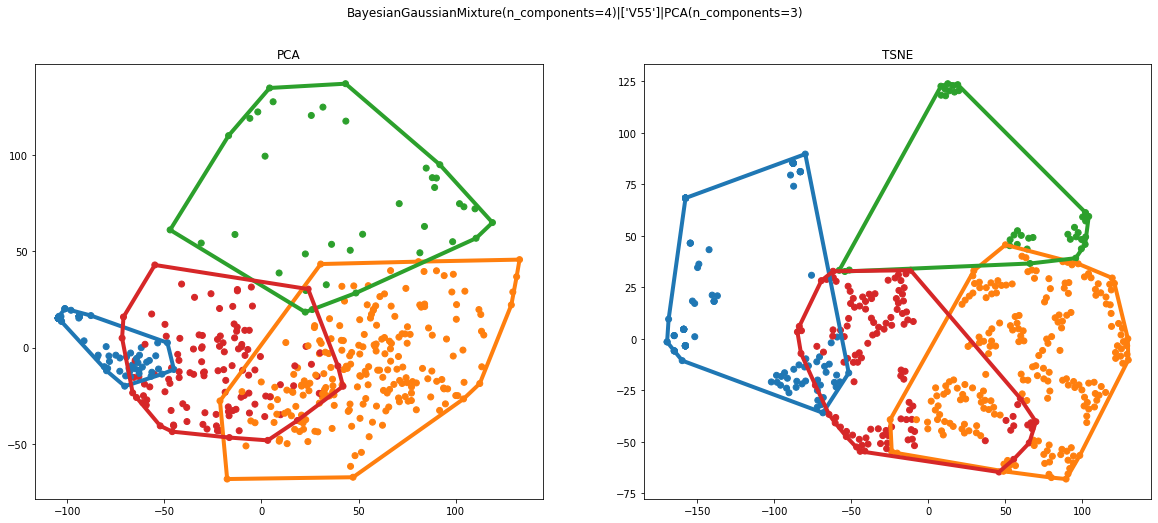

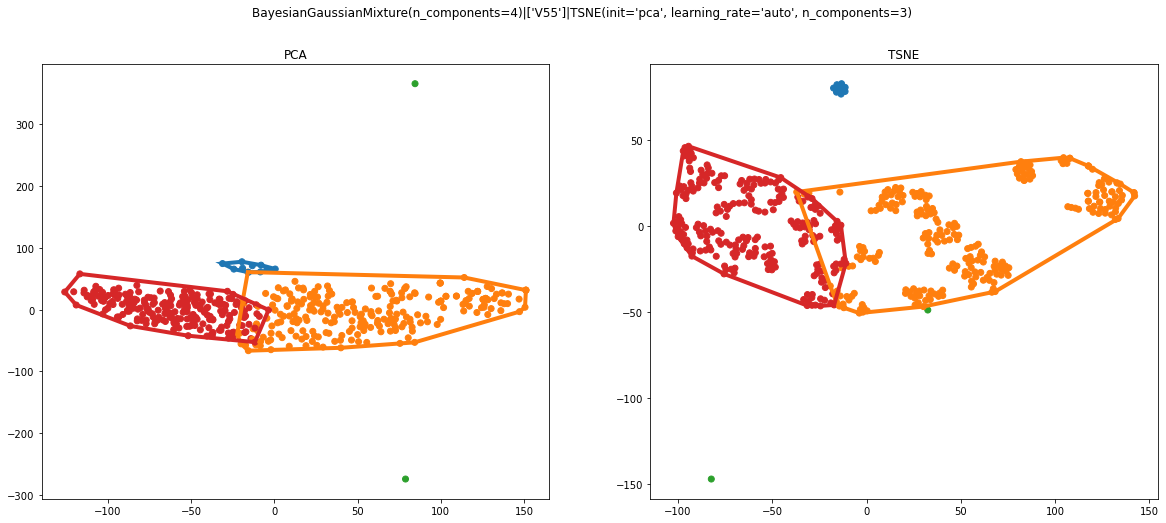

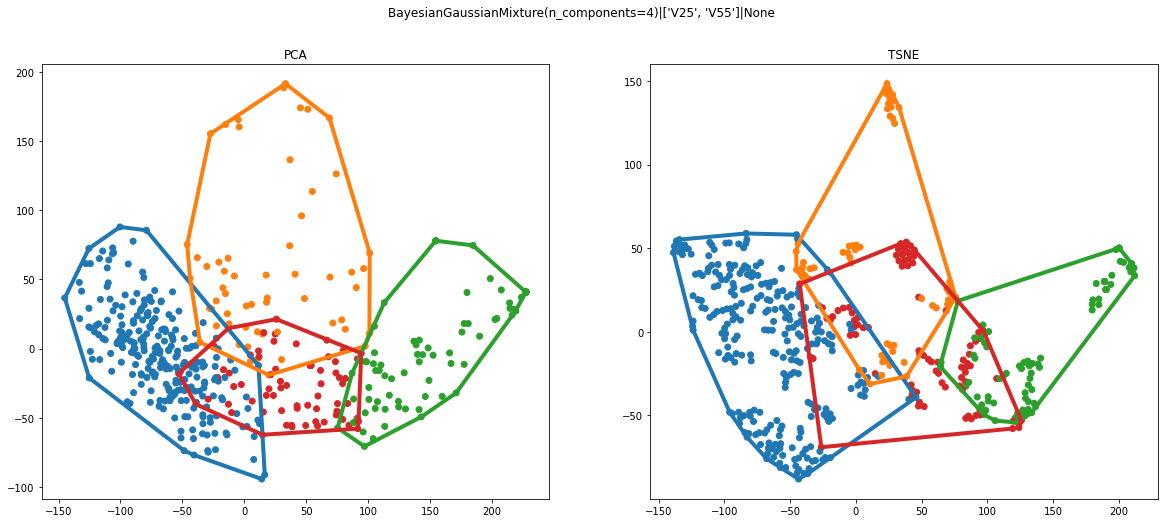

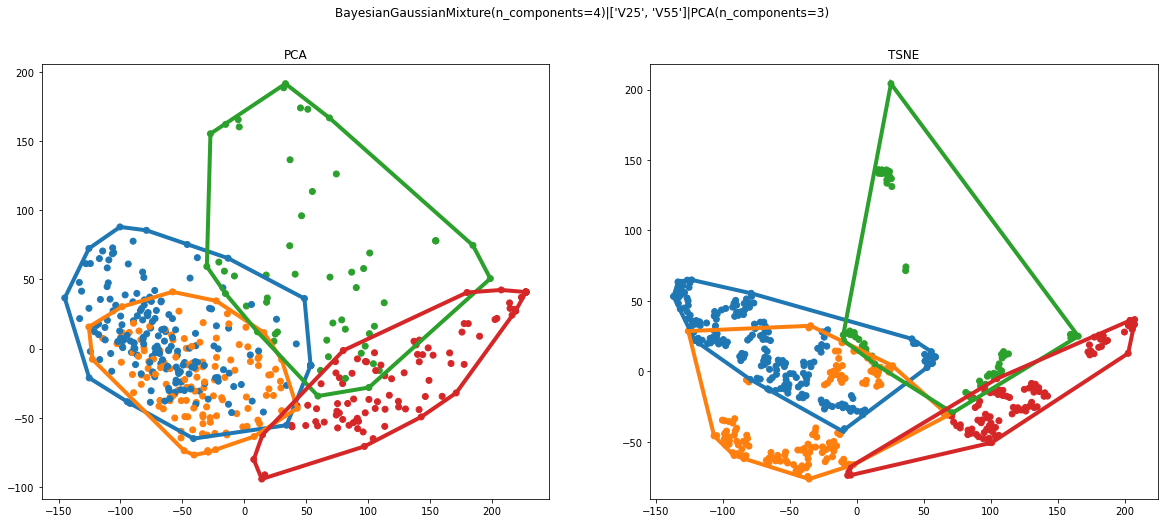

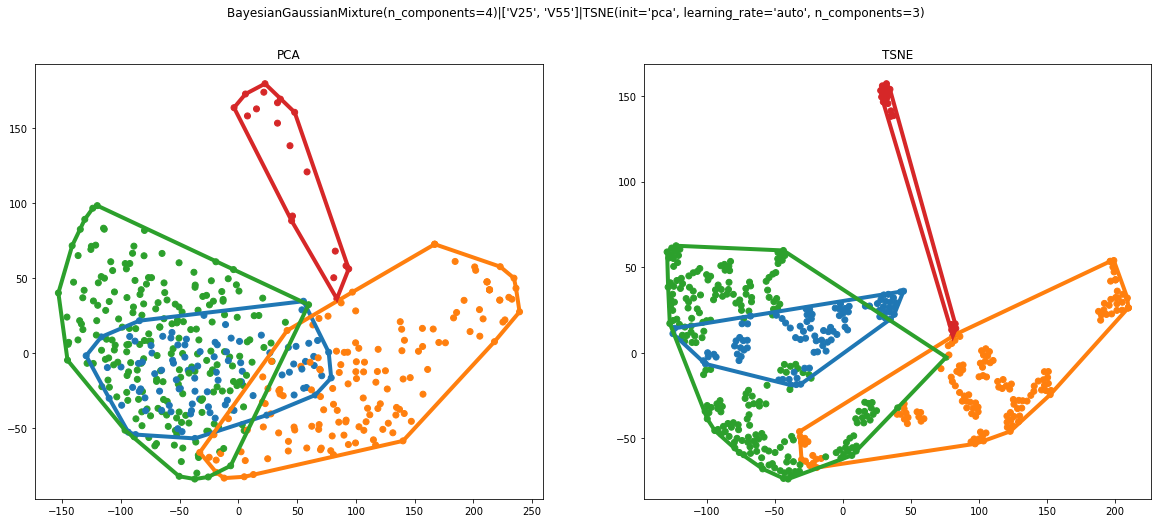

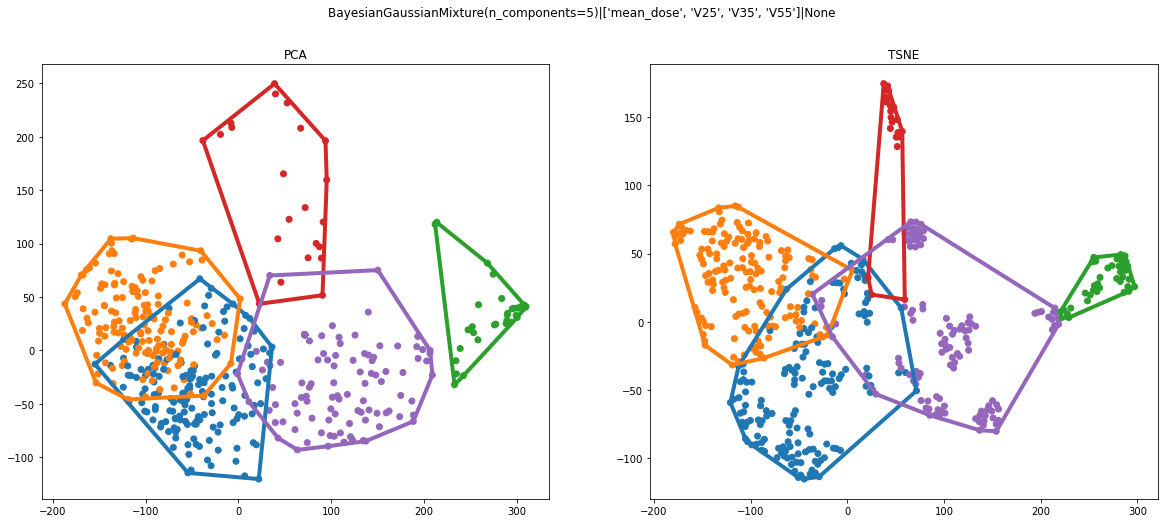

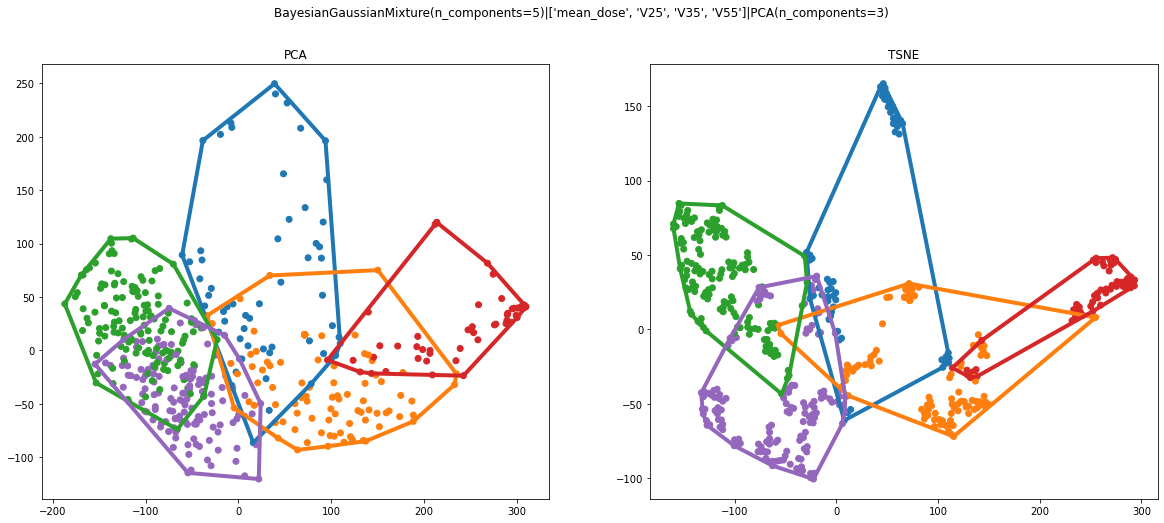

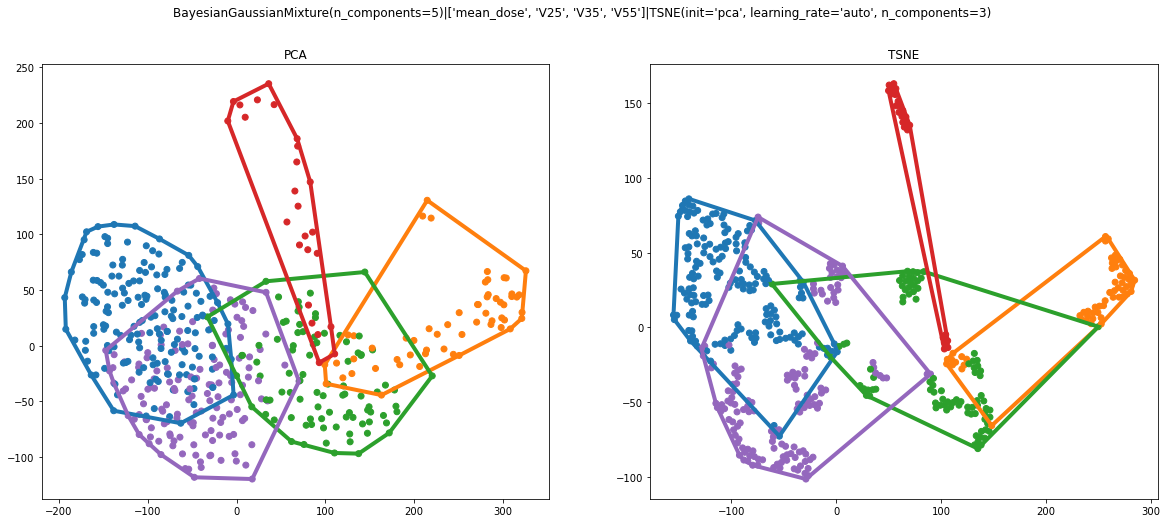

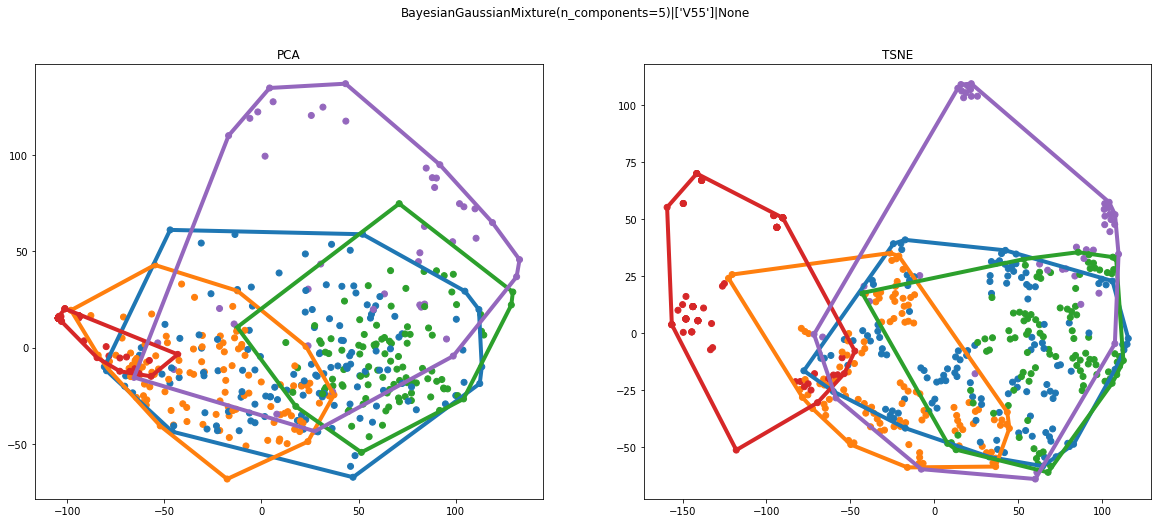

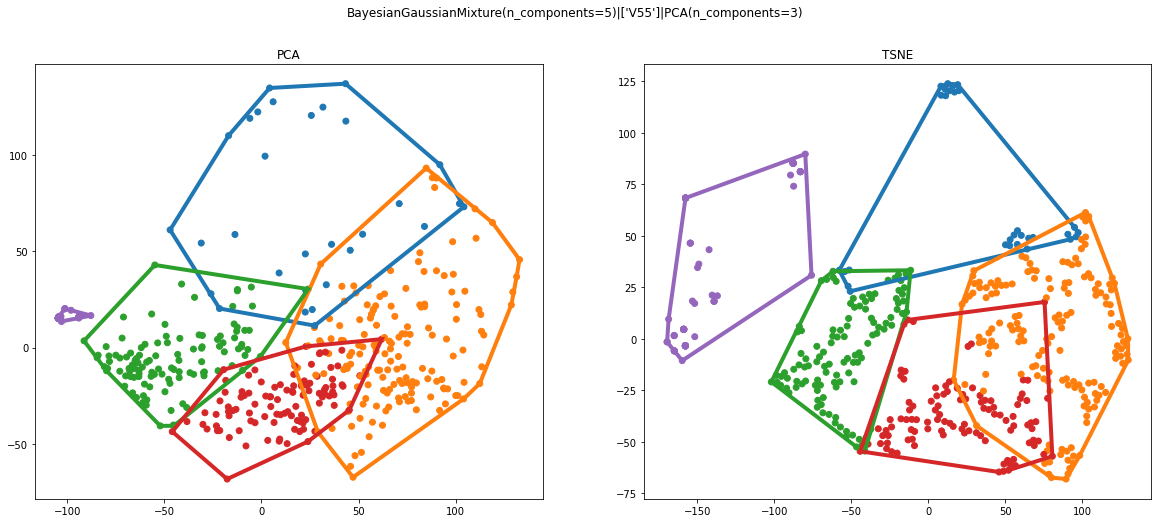

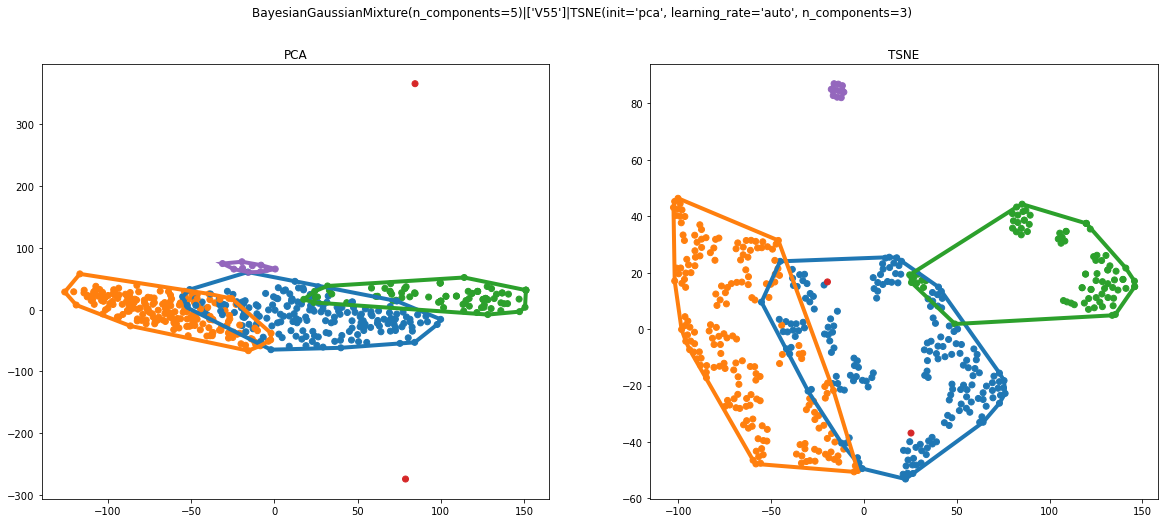

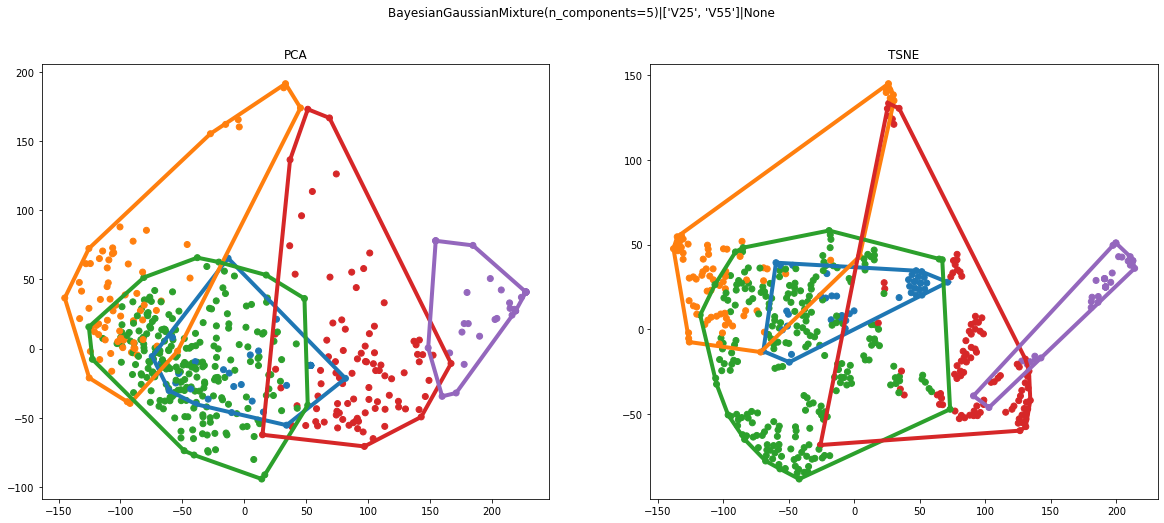

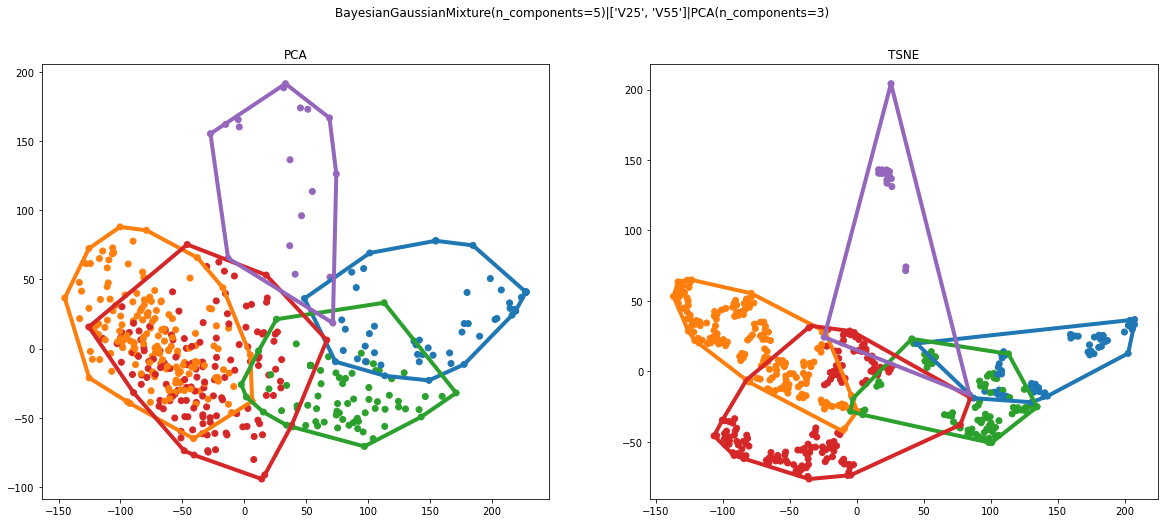

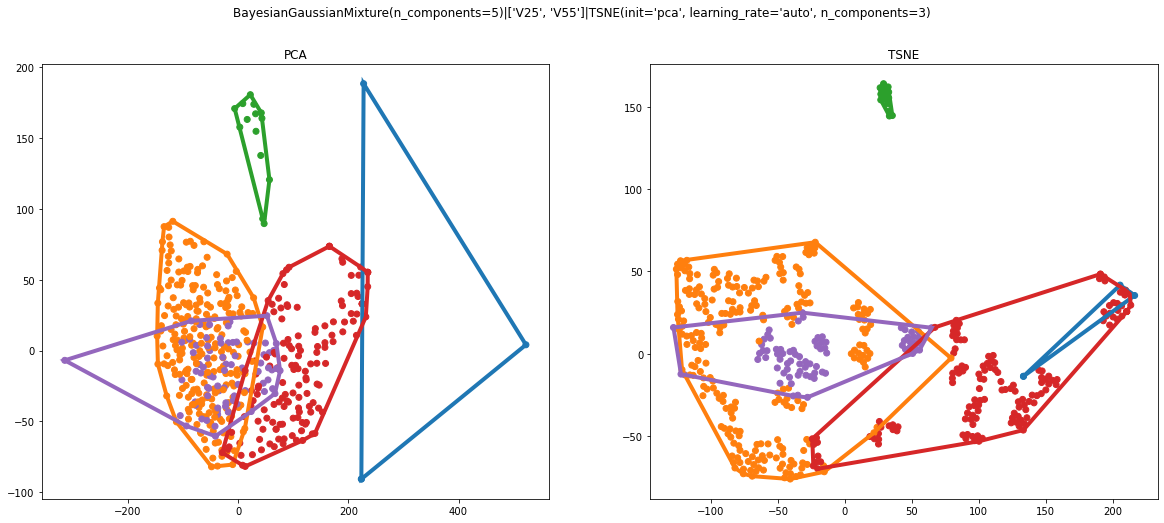

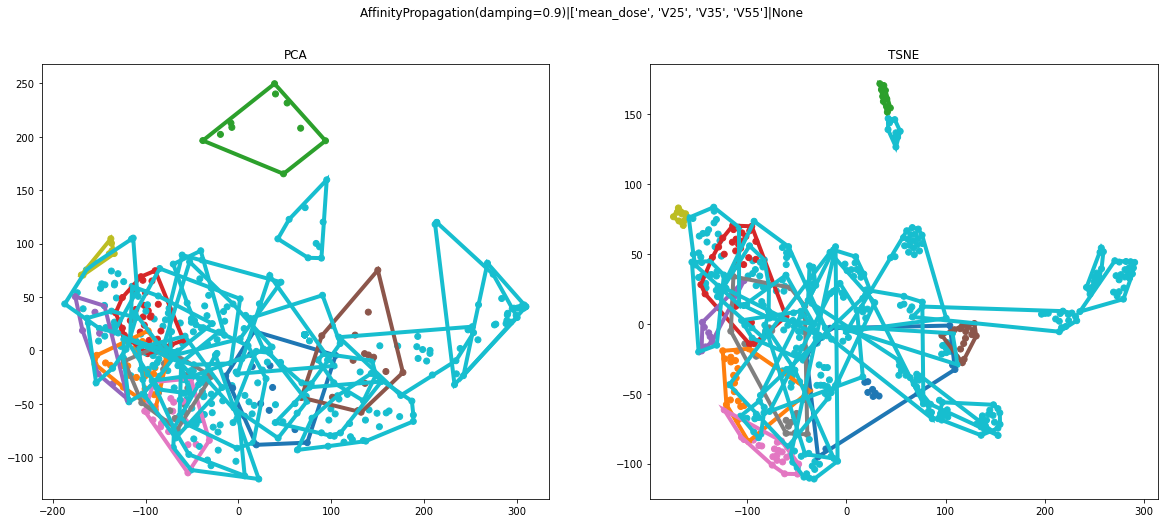

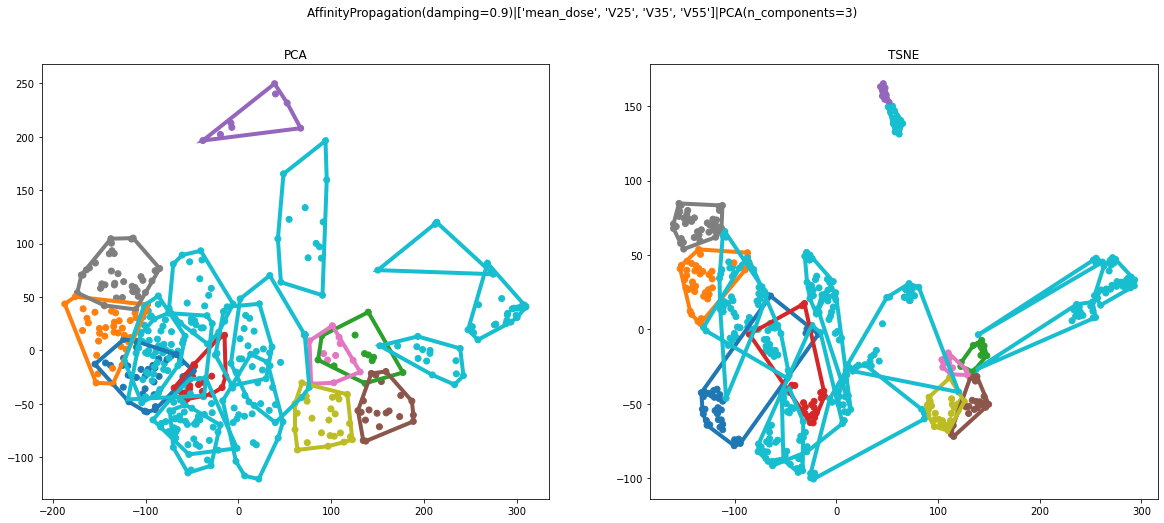

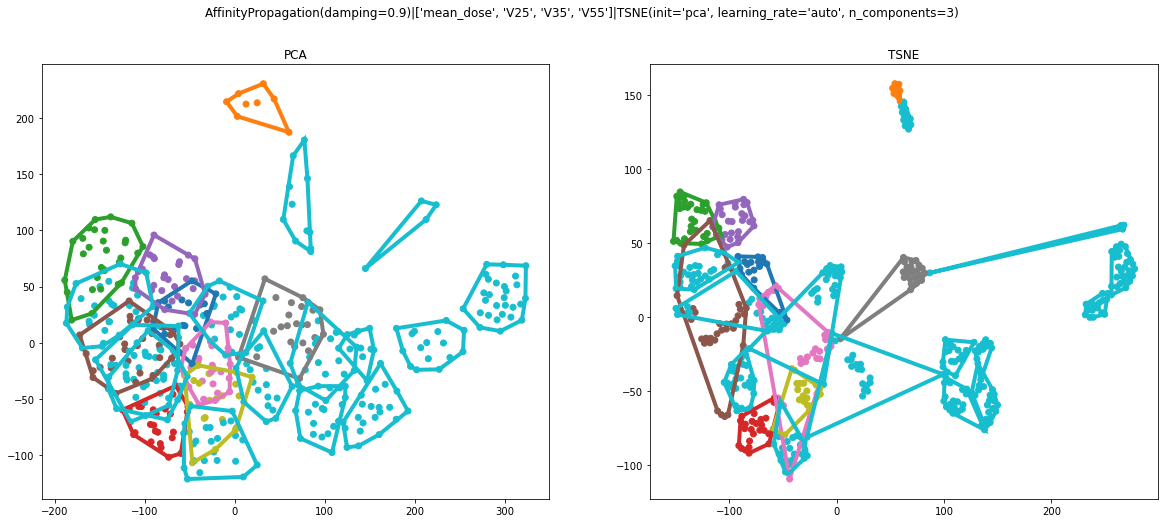

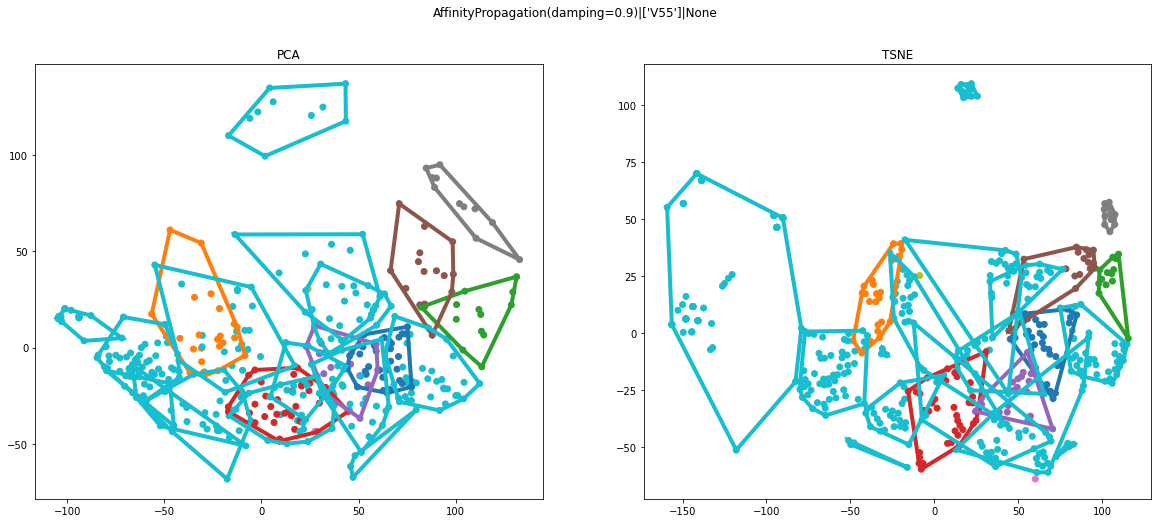

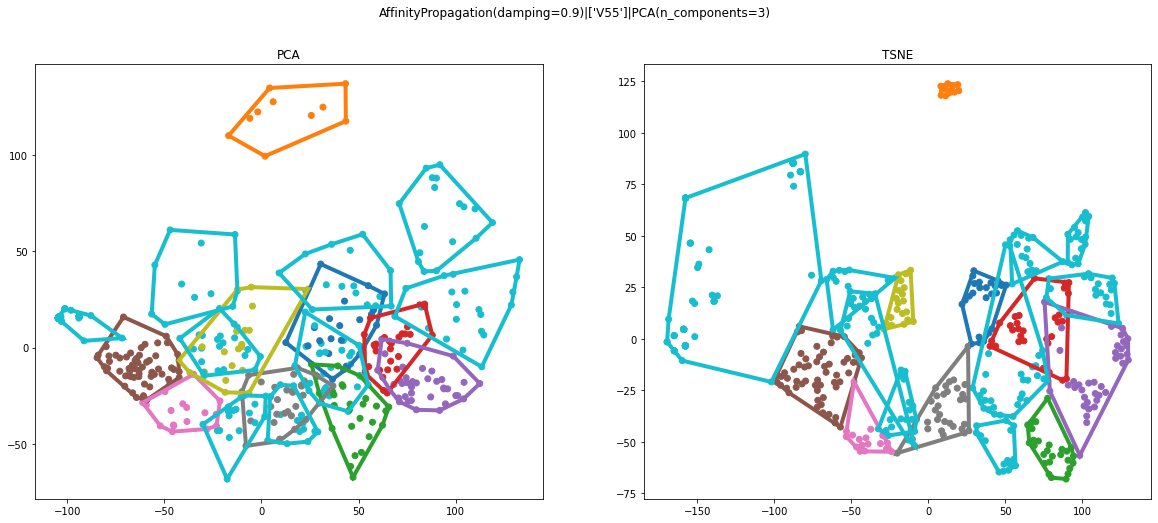

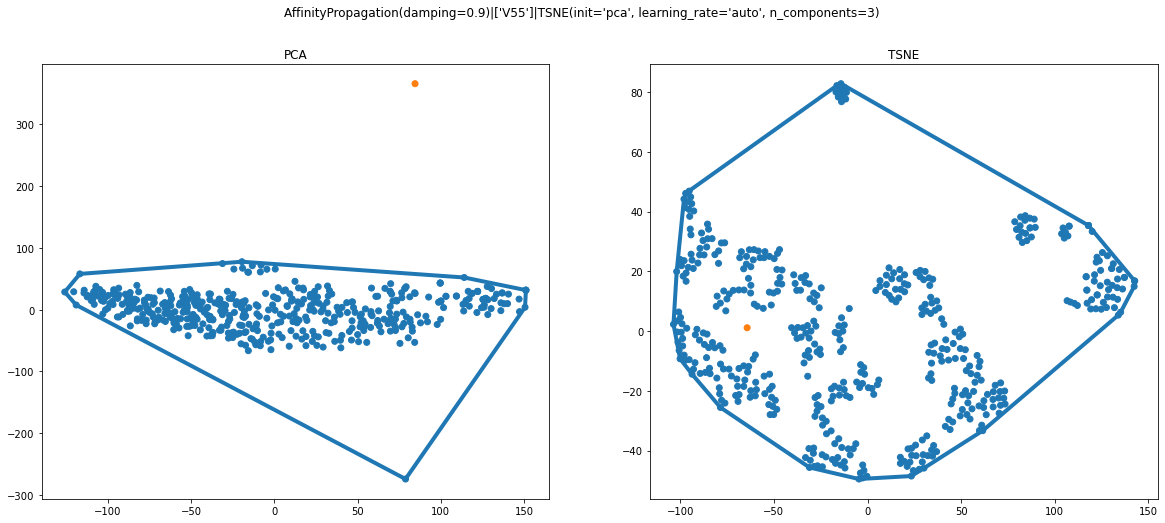

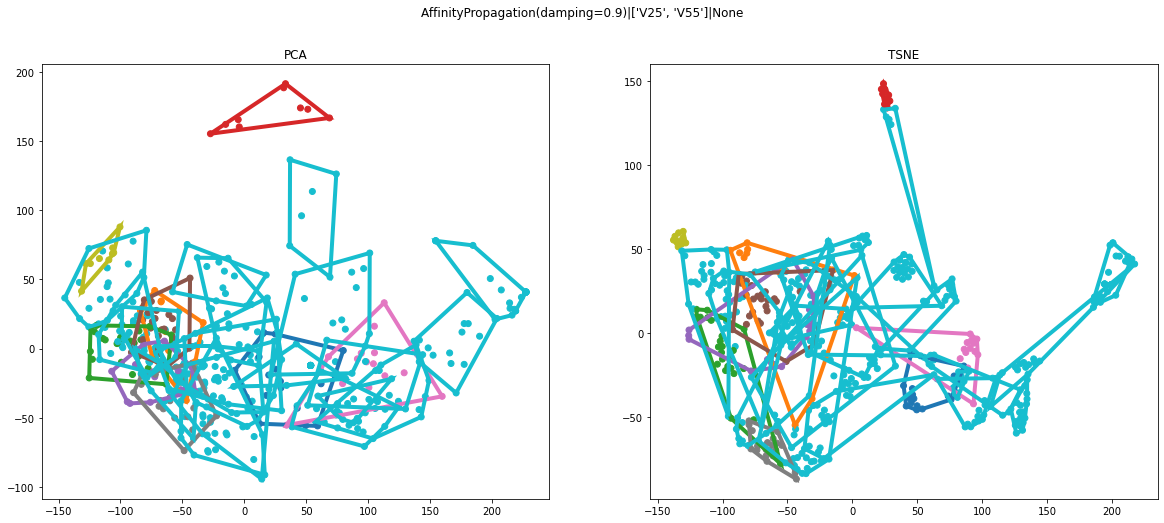

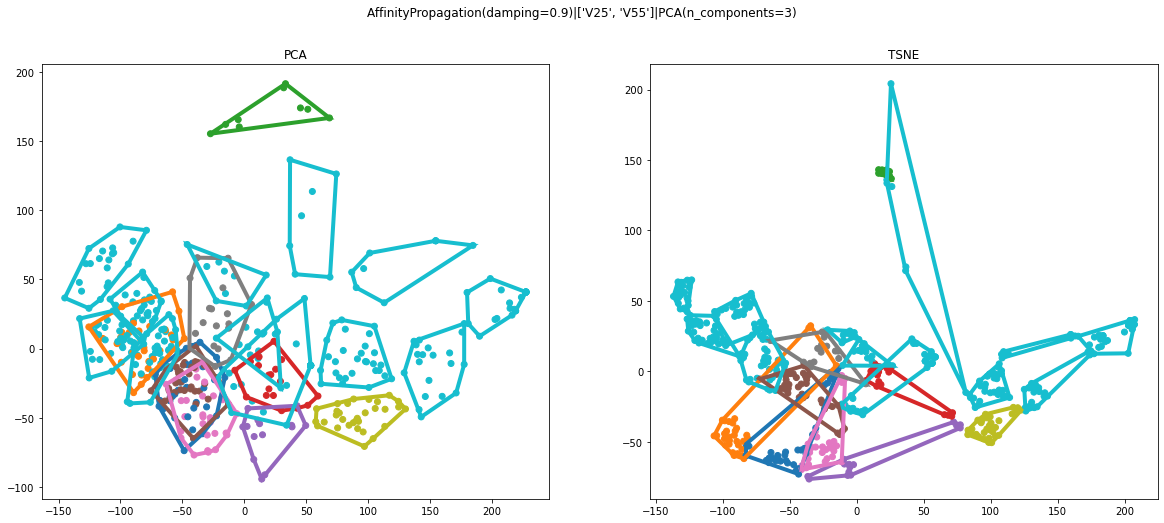

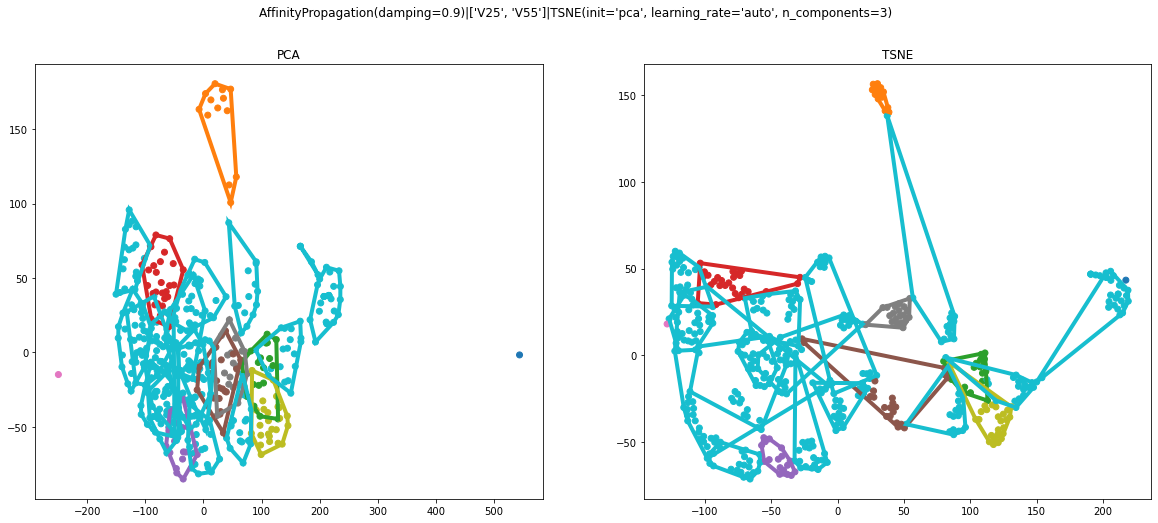

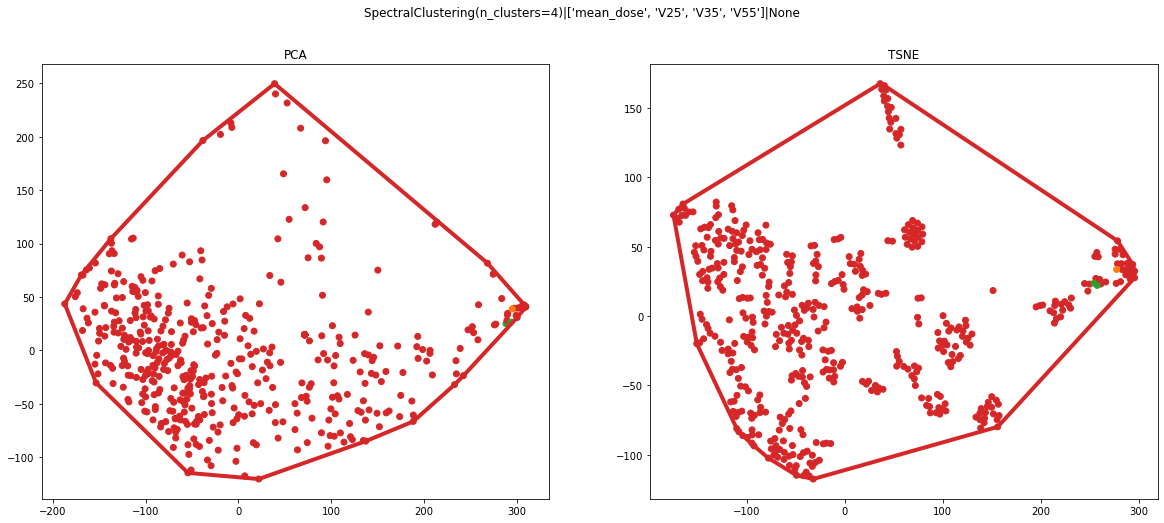

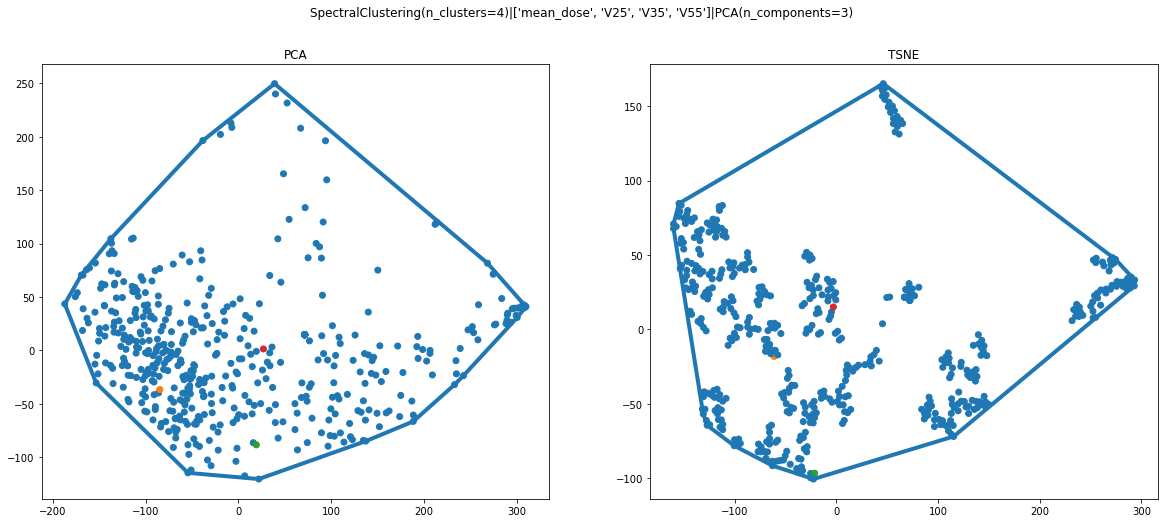

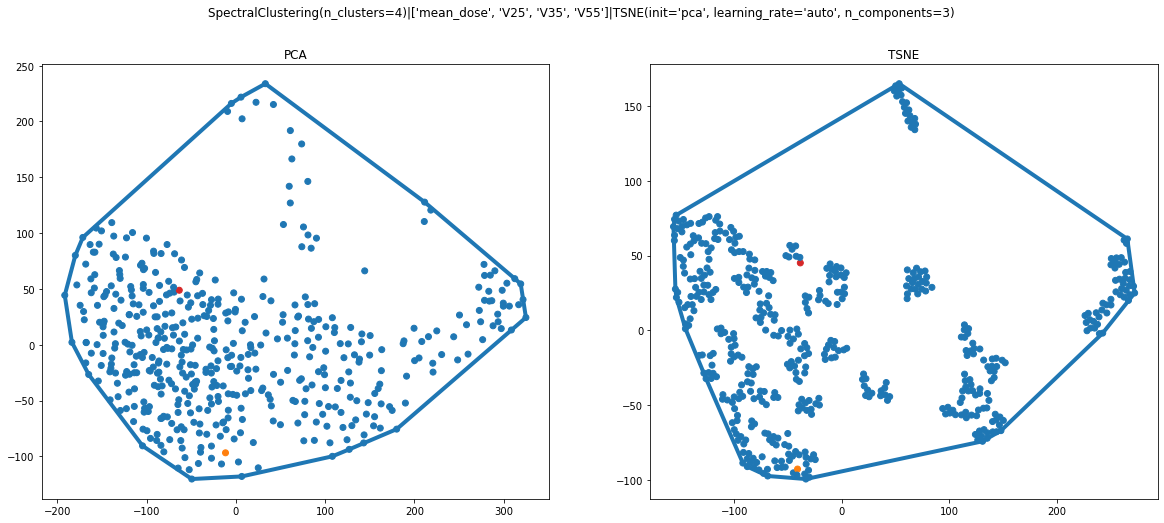

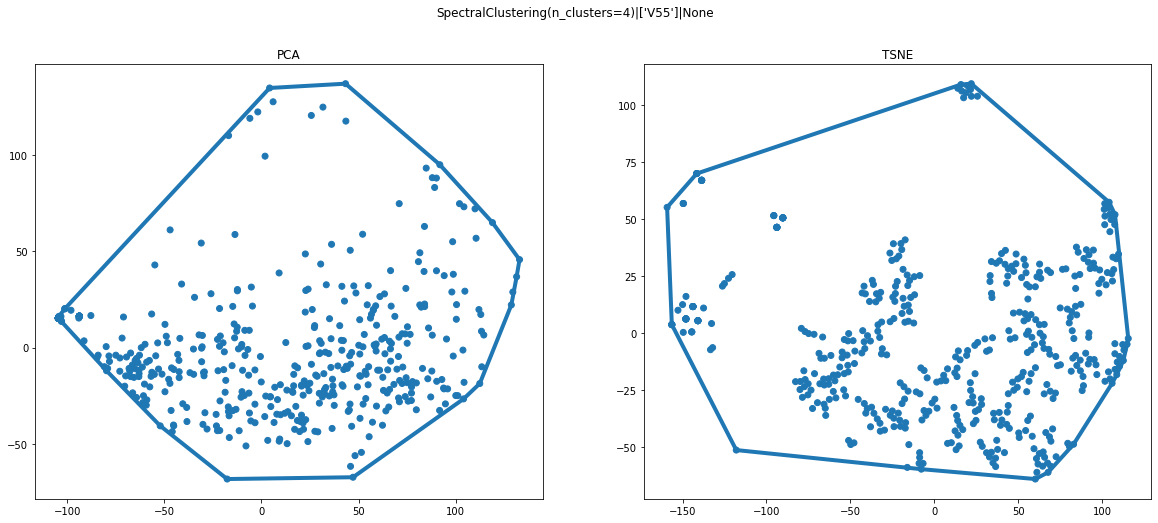

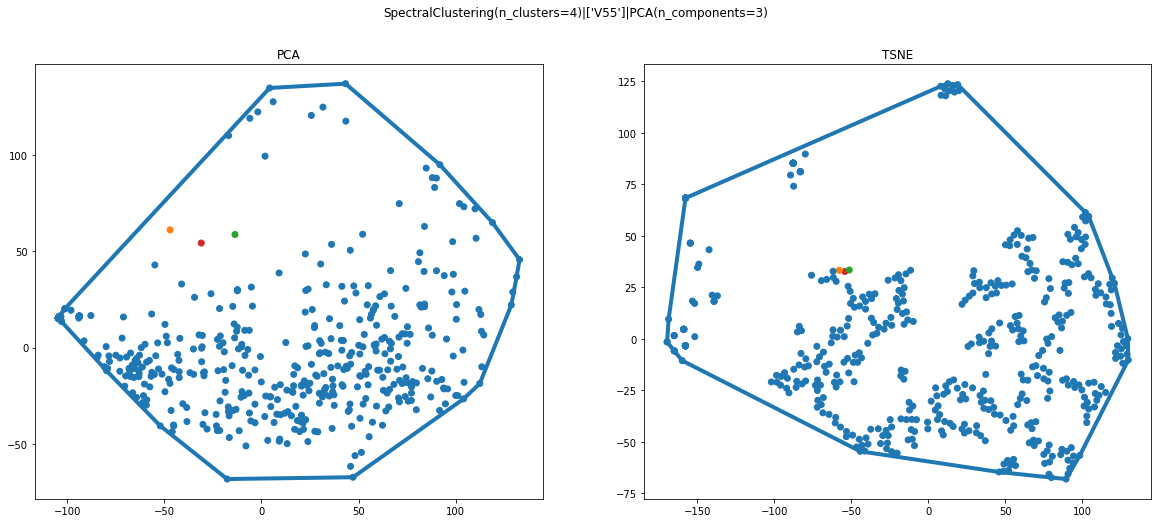

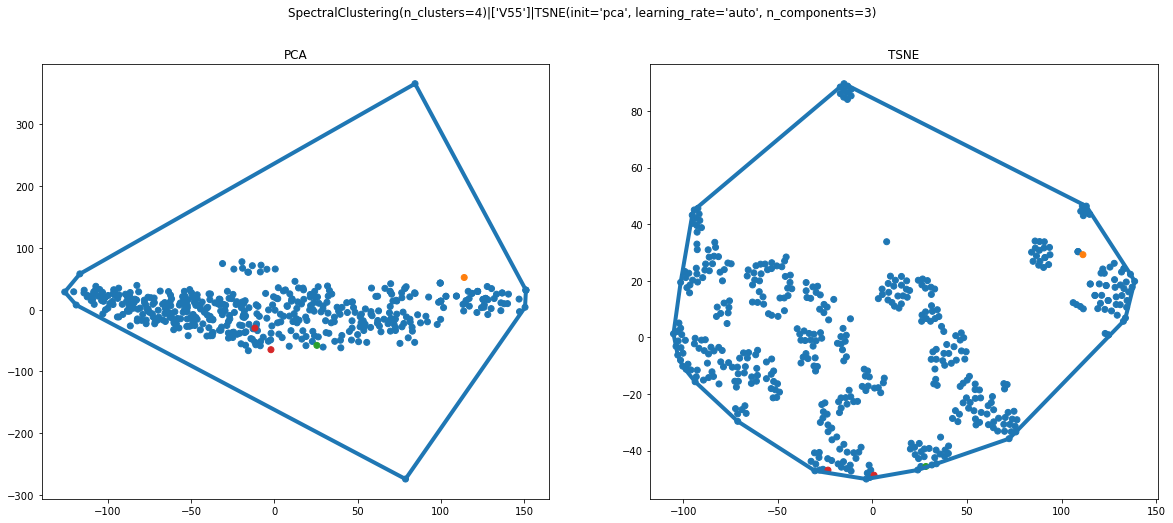

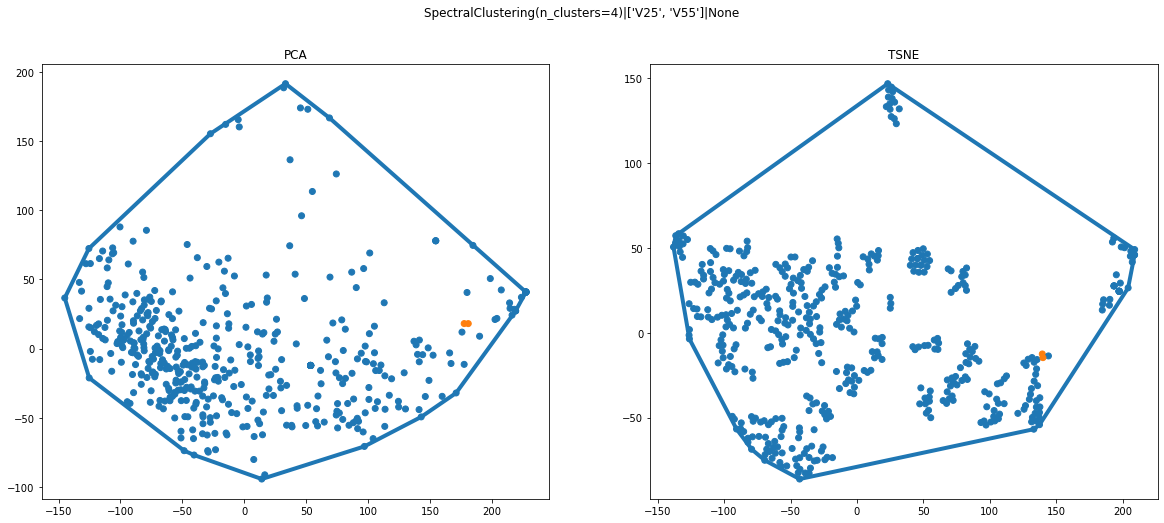

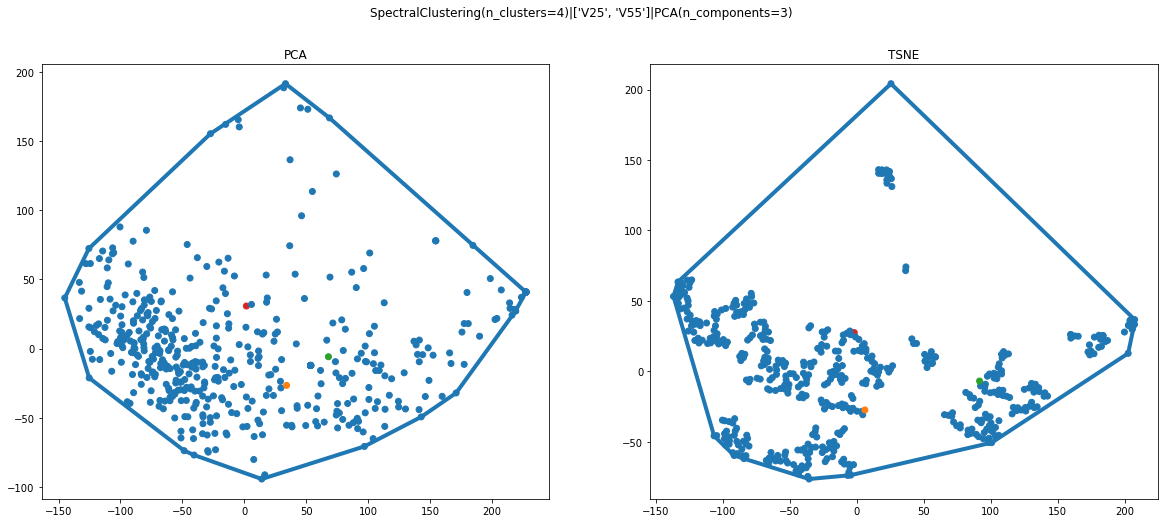

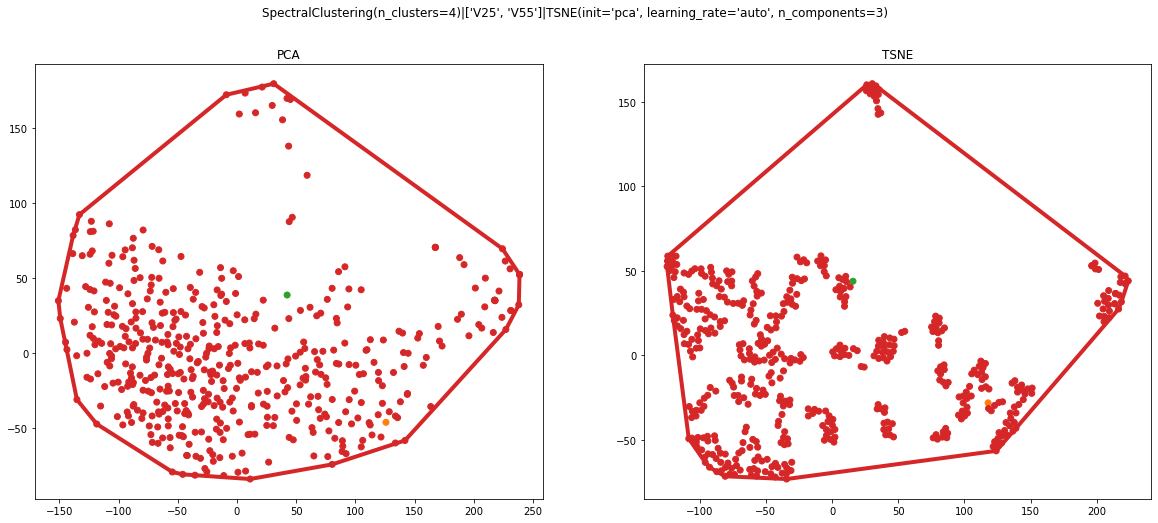

In [46]:
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.cluster import AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

def cluster_and_plot(rdset,clusterer,organ_list=None,features=None,reducer=None,perplexity=10):
    if features is None:
        features = ['mean_dose']
    x = rdset.get_value_array(features,keep_2d=True,organ_list=organ_list)
    if reducer is not None:#pca or something idk
        x = reducer.fit_transform(x)
    clusters = clusterer.fit_predict(x)
    fig,ax = plot_cluster_embeddings(x,clusters,perplexity=perplexity)
    fig.suptitle(str(clusterer) + '|' + str(features) + '|' + str(reducer))
    return

featuresets = [
    ['mean_dose','V25', 'V35', 'V55'],
    ['V55'],
    ['V25','V55']
#     ['mean_dose'],
#     ['mean_dose','volume'],
#     ['V35', 'V40', 'V45'],
#     ['V5','V10','V15','V20','V25','V30','V35',
#      'V40','V45','V50','V55','V60',
#      'V65','V70','V75','V80'],
]
clusterers = [
#     OPTICS(metric='cityblock'),
#     Optics(metric='cosine'),
#     OPTICS(),
    BayesianGaussianMixture(n_components=3, covariance_type="full"),
    BayesianGaussianMixture(n_components=4, covariance_type="full"),
    BayesianGaussianMixture(n_components=5, covariance_type="full"),
    AffinityPropagation(damping=.9),
#     GaussianMixture(4),
#     GaussianMixture(5),
#     GaussianMixture(6),
    SpectralClustering(4),
#     SpectralClustering(5),
]
reducers = [
    None,
    PCA(3),
    TSNE(3,init='pca',learning_rate='auto'),
]
for organ_subset in [organ_subsets[0]]:
    for c in clusterers:
        for f in featuresets:
            for r in reducers:
                try:
                    print('|'.join(organ_subset))
                    cluster_and_plot(rds,c,organ_list=organ_subset,features=f,reducer=r)
                except Exception as e:
                    print(e)

In [ ]:
import re 

def make_sklearn_label(x):
    x = str(x)
    new_x  = re.sub("\\([\s\S]*",'',x).replace("Classifier","").replace("Regression","").replace("(","")
    base = re.match(".*estimator=([a-zA-Z]*).*",x)
    if base is not None:
        suffix = base.group(1)
#         print(x,suffix)
        new_x = new_x + '+' + suffix
    
    return new_x

def final_dvh_bmm_results(rdset,clusterers=None,features=None,plot=True,reducer=None):
    if clusterers is None:
        clusterers = [BayesianGaussianMixture(n_init=4,n_components=5, covariance_type="full",random_state=100)]
    if not Utils.iterable(clusterers):
        clusterers = [clusterers]
    if features is None:
        features=['mean_dose','V65','V45','V35','V25','V15']
    if reducer is None:
        reducer= PCA(len(Const.organ_list))
        
    x = rdset.get_value_array(features,keep_2d=True)
    if reducer is not None:
        x_cluster = reducer.fit_transform(x)
#         print(reducer.explained_variance_ratio_.sum())
    else:
        x_cluster = x[:]
        
    return_cols = ['id','mean_dose','max_dose','volume']
    df = rdset.get_value_array(return_cols,as_df=True,keep_2d=True)
    df = pd.DataFrame(df)
    
    for i,clusterer in enumerate(clusterers):
        clusters = clusterer.fit_predict(x_cluster)
        cluster_probs = clusterer.predict_proba(x_cluster)
        print(np.logical_and(cluster_probs>=.01, cluster_probs<=.99).sum())
        print(clusterer.score(x_cluster))
        if plot:
            fig,ax = plot_cluster_embeddings(x,clusters,perplexity=30)
        df[make_sklearn_label(clusterer)+ '_n=' + str(len(np.unique(clusters)))] = clusters
    return df

temp_clusterers = [
    BayesianGaussianMixture(n_init=4,n_components=6, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=5, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=4, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=3, covariance_type="full",random_state=100),
]

dcluster_df = final_dvh_bmm_results(rds,
                                    clusterers = temp_clusterers,
                                    )
dcluster_df.to_csv(Const.data_dir + 'dvh_cluster_12172021.csv')
dcluster_df

In [ ]:
import torch.nn.functional as F

class DvhAutoEncoder(nn.Module):
    
    def __init__(self,
                input_size,
                embedding_dim = 20,
                pre_embedding_dim = 100,
                conv_channels = 2, 
                init_dropout = .2,
                embedding_dropout = .2,
                penult_dropout = .2
                ):
        
        super().__init__()
            
        self.input_size = input_size
        self.n_channels = input_size[-1]
        self.n_organs = input_size[1]
        
        self.init_dropout = init_dropout
        self.embedding_dim =  embedding_dim
        self.pre_embedding_dim = pre_embedding_dim
        self.conv_channels = conv_channels
        
        self.embedding_dropout = embedding_dropout
        self.penult_dropout = penult_dropout
        self.conv_droput = nn.Dropout2d(p=self.init_dropout)
        self.flatten = nn.Flatten().cuda()
        
        self.encoder = self.init_encoder()
        self.decoder = self.init_decoder()
        
    def init_encoder(self):
        conv_in = nn.Conv1d(self.n_channels,self.conv_channels,
                            padding='same')
        #I think this is what the size should be
        conv_dim = self.conv_channels * self.n_organs
        fc_in_1 = nn.Linear(conv_dim, self.pre_embedding_dim)
        embedding_layer = nn.Linear(self.pre_embedding_dim,self.embedding_dim )
        encoder = nn.Sequential(
            self.conv_droput,
            conv_in,
            self.flatten,
            nn.Relu(),
            fc_in_1,
            nn.Relu(),
            embedding_layer,
            nn.Dropout(p=self.embedding_dropout),
            nn.LazyBatchNorm1d(),
        )
        return encoder
    
    def init_decoder(self):
        #idk
        fc_out_1 = nn.LazyLiner(self.pre_embedding_dim)
        conv_dim = self.conv_channels * self.n_organs
        fc_out_2 = nn.Linear(self.pre_embedding_dim)
        conv_out = nn.ConvTranspose1d(self.pre_embedding_dim)
        
    def encode(self,x):
        #I think I need to figure out alignment here
        pass
    
    def decode(self,x):
        pass
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def forward(self,xin):
        #we keep in nans in the data so I can ignore them in the loss function
        x = torch.nan_to_num(xin)
        #channel should be the 2nd dim for conv networks, I use 3rd usually
        x = x.permute(0,2,1)
        x = self.encode(x)
        x = self.decode(x)
        return x
    
volume_dvh